# Von Karman Vortex Shedding at Re=100
By Alan Kaptanoglu and Jared Callaham

This example is based on the manifold model, POD-Galerkin models, and constrained SINDy models of the following papers:

1. Schlegel 2013. On long-term boundedness of Galerkin models
2. Noack, 2003. A hierarchy of low-dimensional models for the transient and post-transient cylinder wake.
3. Loiseau 2018 Constrained sparse Galerkin regression. and uses some of the constrained and advanced SINDy features illustrated in examples 7 and 8.
The goal of this example is to show a detailed comparison of Galerkin models for the Re=100 von Karman shedding, between a center manifold model, a number of calculated POD-Galerkin models, and unconstrained/constrained SINDy models.

### Setup

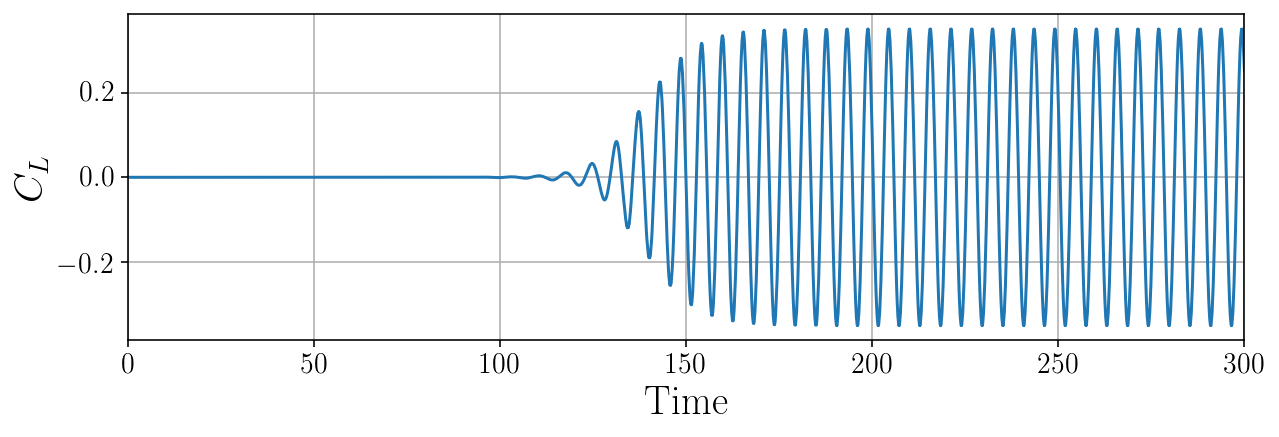

Strouhal number: 0.1800
Uncertainty +/- 0.0100
Approximate period: 5.5556


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import pysindy as ps
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import complex_ode

mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(12, 8))
%config InlineBackend.figure_format = 'retina'

mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

galerkin = sio.loadmat('models/galerkin9.mat')
L = galerkin['L']
#with np.printoptions(precision=4, suppress=True):
#    print(L)
# Load aerodynamic moments
data = np.loadtxt('./forceCoeffs.dat', skiprows=1)
t_coeff = data[:, 0]
CD = data[:, 1]
CL = data[:, 2]

# Get rid of duplicates
t_coeff, idx = np.unique(t_coeff, return_index=True)
CD = CD[idx]
CL = CL[idx]

plt.figure(figsize=(10, 3))
plt.plot(t_coeff, CL, label='DNS')
plt.xlabel('Time')
plt.ylabel(r'$C_L$')
plt.grid()
plt.xlim([0, 300])
plt.show()
# Stabilizes after ~25000 time steps
dt = t_coeff[1]-t_coeff[0]
E = np.abs((dt*np.fft.fft(CL[t_coeff>200]))**2)
E = E[:int(len(E)/2)]
N = len(E)
freq = np.arange(N)/(2*dt*N)

St = freq[np.argmax(E)]
print('Strouhal number: {0:0.4f}'.format(St))
print('Uncertainty +/- {0:0.4f}'.format(freq[1]-freq[0]))

print('Approximate period: {0:0.4f}'.format(1/St))
#print(dt)

### POD-Galerkin models

(3000, 9)


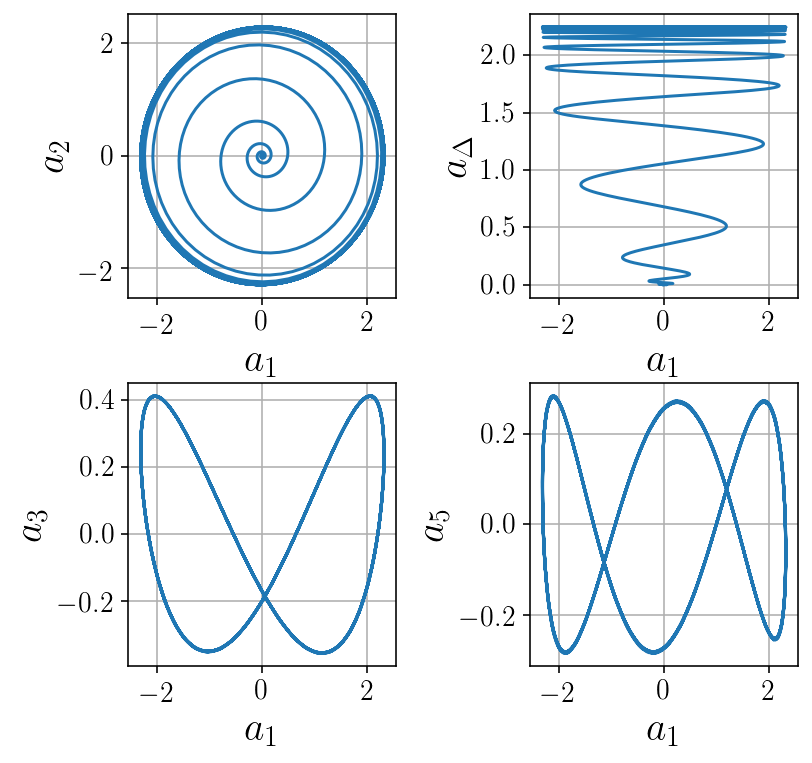

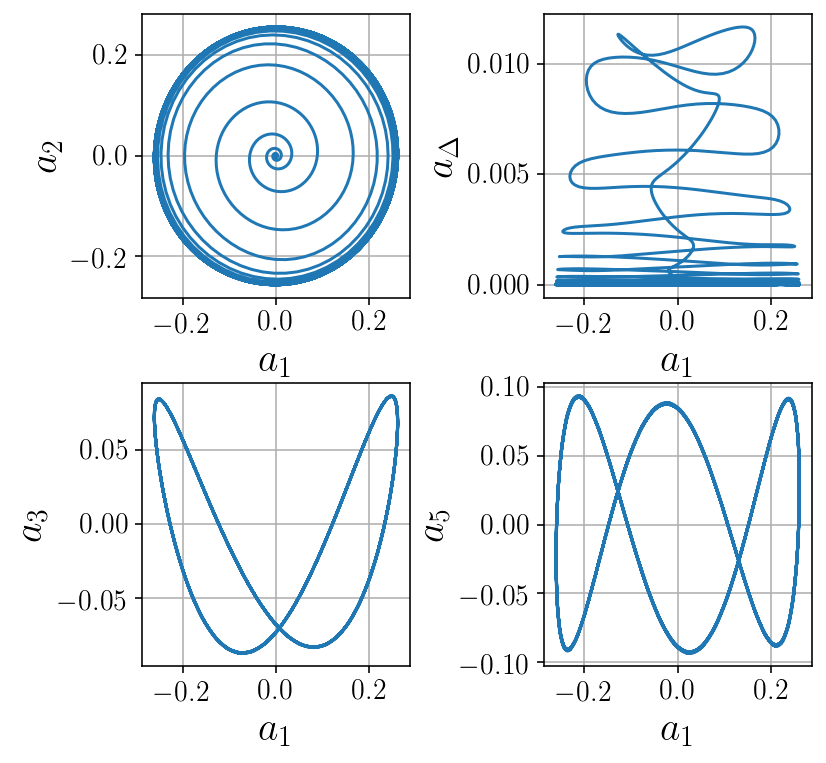

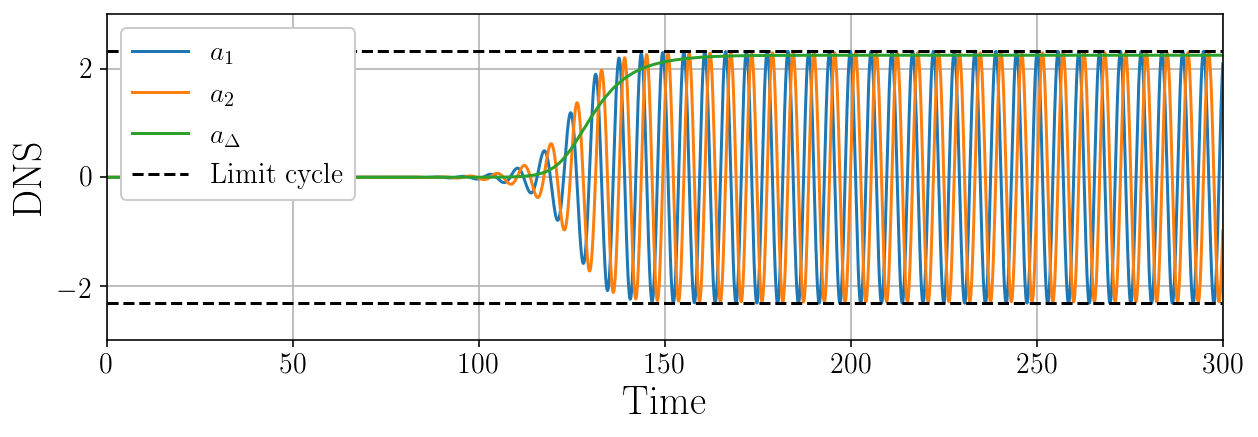

In [2]:
a = np.loadtxt('./a.dat')
t = a[:, 0]
a = a[:, 1:]
a_dot = np.zeros(a.shape)
for i in range(a.shape[1]):
    a_dot[:, i] = np.asarray(np.gradient(a[:, i]))
print(a_dot.shape)
a_max = max(a[:, :2].flatten())

t_steady = 250

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a_dot[t>t_steady, 0], a_dot[t>t_steady, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a_dot[t>t_steady, 0], a_dot[t>t_steady, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

a_max = max(abs(a[:, 0]))

plt.figure(figsize=(10, 3))
plt.plot(t, a[:, [0, 1, -1]])
plt.plot([t[0], t[-1]], [a_max, a_max], 'k--')
plt.plot([t[0], t[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()

#plt.savefig(fig_dir+'deane_model.svg')
plt.show()


### Compare 3-mode (shift-mode) POD-Galerkin model with DNS

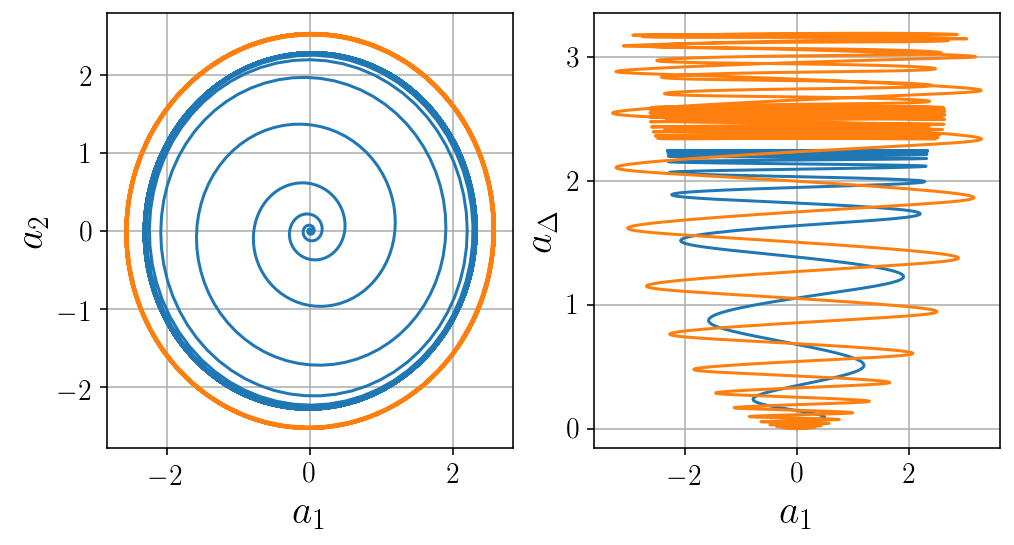

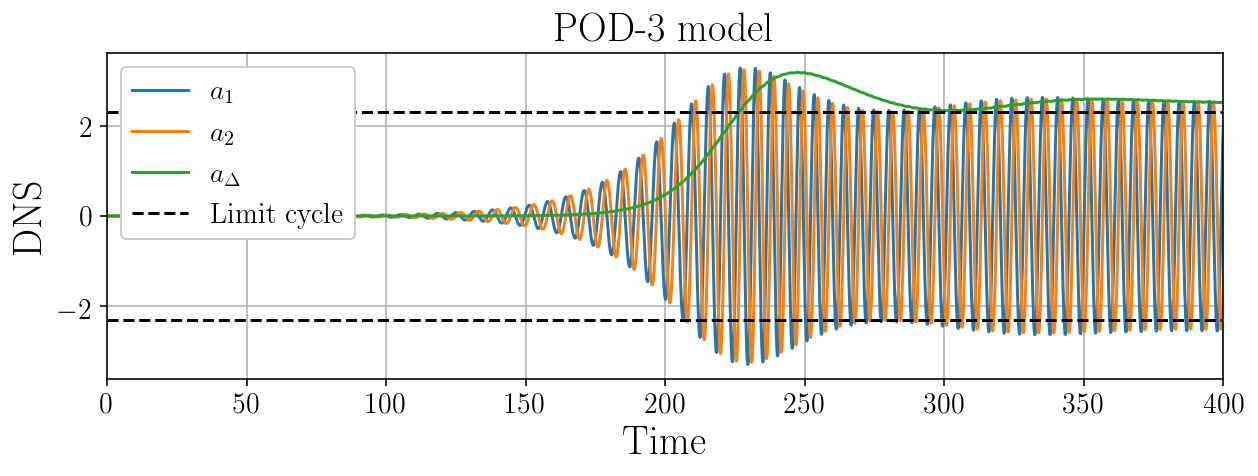

In [3]:
def pg_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)

galerkin3 = sio.loadmat('models/galerkin3.mat')
model3 = lambda a, t: pg_model(a, galerkin3['L'], galerkin3['Q'])

galerkin9 = sio.loadmat('models/galerkin9.mat')
model9 = lambda a, t: pg_model(a, galerkin9['L'], galerkin9['Q'])

# Simulate Galerkin models
t_sim = np.arange(0, 500, dt * 10)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.real( 1e-3*Phi[:, :2] @ np.random.random((2)) )

a_galerkin3 = odeint(model3, a0[:3], t_sim)
a_galerkin9 = odeint(model9, a0[:9], t_sim)
# Plot Galerkin-3 results
t_steady_sim = 400

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_galerkin3[t_sim>t_steady_sim, 0], a_galerkin3[t_sim>t_steady_sim, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(122)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_galerkin3[:, 0], a_galerkin3[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()
plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_galerkin3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.xlim([0, 400])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()
plt.title("POD-3 model")

plt.show()

### Compare 9-mode (shift-mode) POD-Galerkin model with DNS

[[1.2030129e-07 4.1603837e-08 2.3466293e-09]
 [2.3466293e-09 4.1603837e-08 1.2030129e-07]
 [5.8910005e-02 3.8263455e-03 1.3287652e-04]
 [1.3287652e-04 3.8263455e-03 5.8910005e-02]
 [8.8669622e-04 7.8507870e-01 8.8669622e-04]
 [1.1483223e-05 6.0974548e-07 1.8397255e-07]
 [1.8397255e-07 6.0974548e-07 1.1483223e-05]
 [6.6886016e-04 1.7040549e-04 2.2871853e-05]
 [2.2871853e-05 1.7040549e-04 6.6886016e-04]]


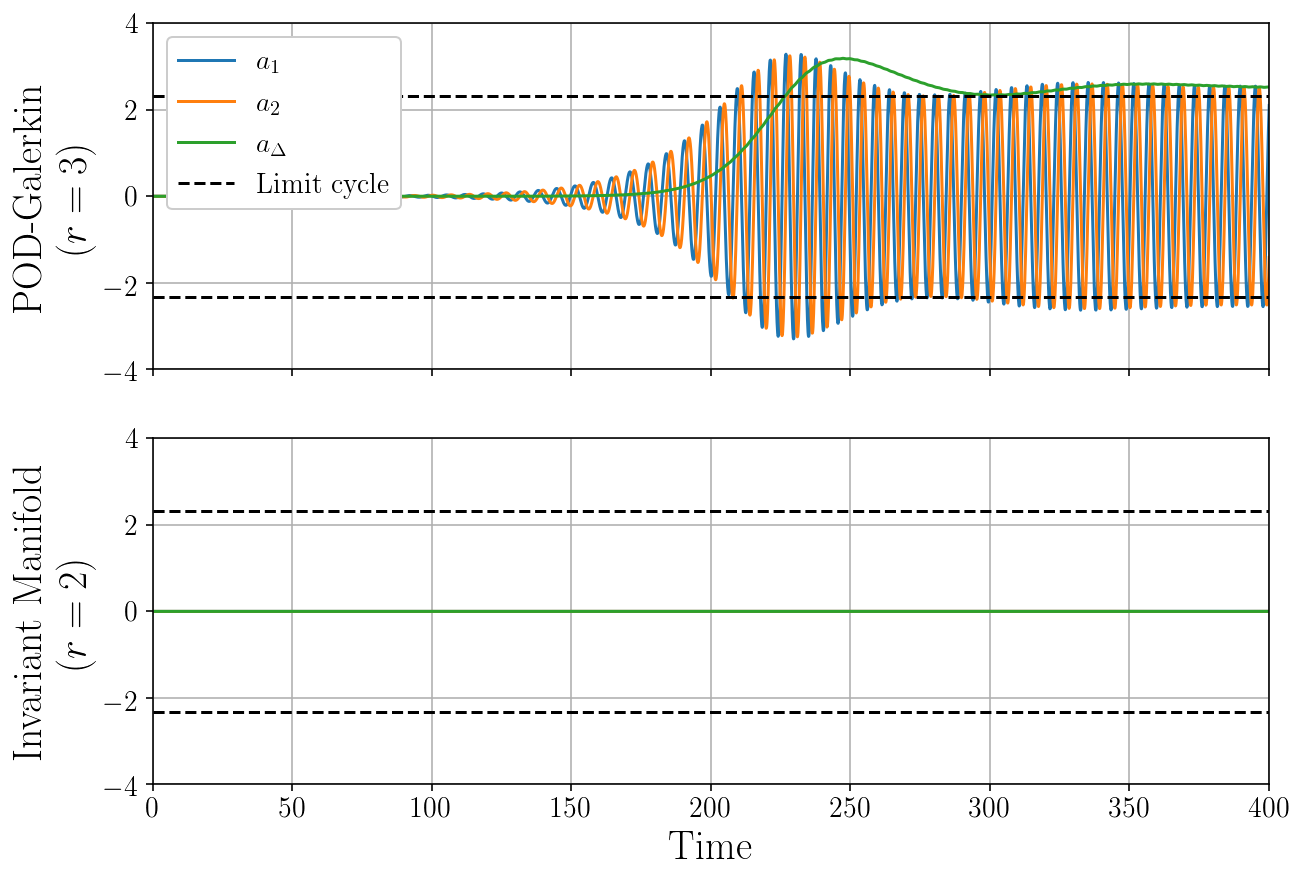

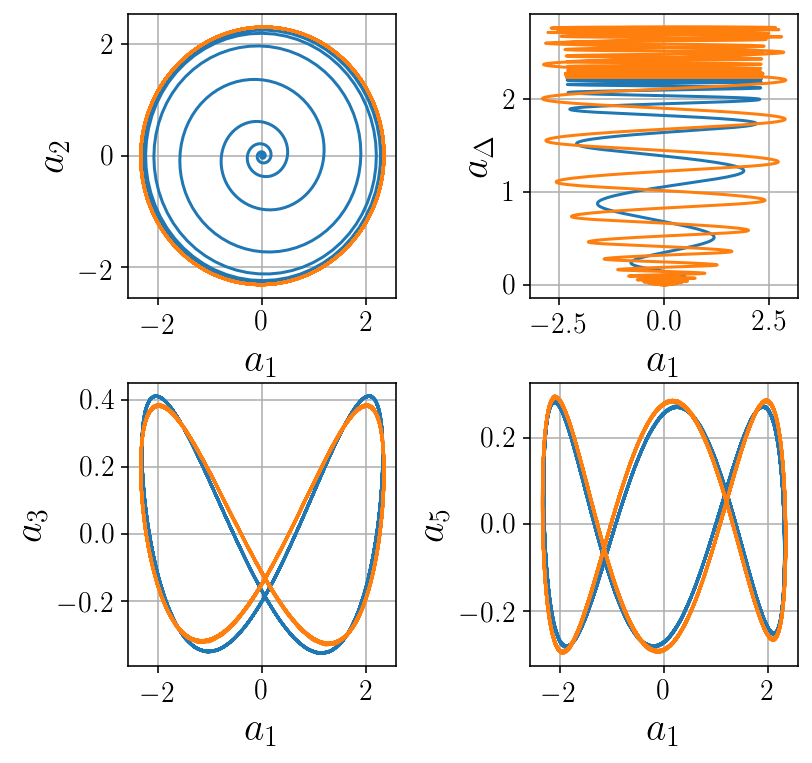

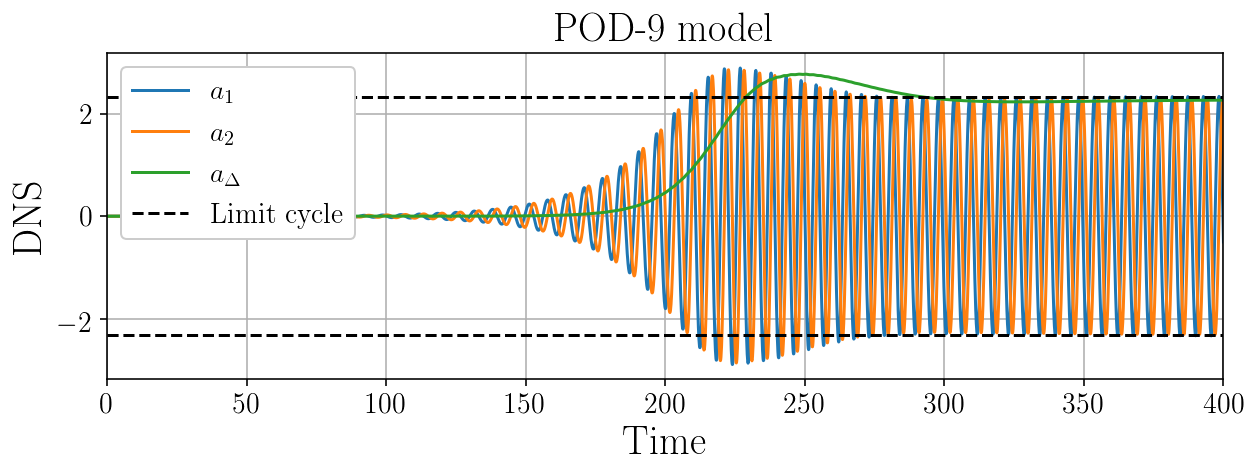

In [4]:
r = 9
L = galerkin9['L']
Q = galerkin9['Q']

# Eigendecomposition of linear part of Galerkin model
evals, Phi = np.linalg.eig(L)

# Order by real part, so unstable evals are first
sort_idx = np.argsort(-np.real(evals))
evals = evals[sort_idx]
Phi = Phi[:, sort_idx]
Phi_inv = np.linalg.inv(Phi)

L_nf = Phi_inv @ L @ Phi
Q_nf = np.einsum('nlm,in,lj,mk->ijk', Q, Phi_inv, Phi, Phi)

model_nf = lambda t, b: pg_model(b, L_nf, Q_nf)

# Don't need to re-center on fixed point since we expanded around the steady state
#  (Otherwise this would be a0 - a_s)
b0 = Phi_inv @ a0[:r]

# Assume that the eigendecomposition actually did
#    diagonalize the upper block of the "normal form"
L11 = 1j*np.imag(L_nf[0, 0])
L22 = 1j*np.imag(L_nf[1, 1])

#L11 = L_nf[0, 0]
#L22 = L_nf[1, 1]

# Build the big matrix for the linear algebra problem
L_mat = np.zeros((3*r, 3*r), dtype='complex64')
L_mat[:r, :r] = 2*L11*np.eye(r) - L_nf
L_mat[r:-r, r:-r] = (L11+L22)*np.eye(r) - L_nf
L_mat[-r:,-r:] = 2*L22*np.eye(r) - L_nf

q_vec = np.zeros((3*r), dtype='complex64')
q_vec[:r] = Q_nf[:, 0, 0]
q_vec[r:-r] = Q_nf[:, 0, 1] + Q_nf[:, 1, 0]
q_vec[-r:] = Q_nf[:, 1, 1]

h_vec = np.linalg.inv(L_mat) @ q_vec
H = np.zeros((r, 3), dtype='complex64')
H[:, 0] = h_vec[:r]
H[:, 1] = h_vec[r:-r]
H[:, 2] = h_vec[-r:]

# Print analytic manifold equation
print(abs(H))

# Create a function for the manifold model (assuming leading two coordinates are driving)
order = 2
def manifold_eq(b, H, order):
    # 2D Polynomial library
    lib = np.array([b[0]**(i-j)*b[1]**j for i in range(2, order+1) for j in range(i+1)])
    b_poly = H @ lib  # Manifold equation
    b_poly[:2] = b[:2]  # Leave active coordinates unchanged
    return b_poly

def dae_model(b, L, Q, H, order):
    # Slave coordinates to the manifold and then evolve with the full model
    b_full = manifold_eq(b, H, order)
    db = pg_model(b_full, L, Q)
    return db[:2]

model = lambda t, b: dae_model(b, L_nf, Q_nf, H, order)

#b0 = Phi_inv @ (a0 - a_s)

b0_manifold = b0[:2]
integrator = complex_ode(model)
integrator.set_initial_value(b0_manifold, 0)

b_manifold = np.zeros((2, len(t_sim)), dtype='complex64')
idx = 0
while integrator.successful() and idx<len(t_sim)-1:
    idx+=1
    integrator.integrate(integrator.t+dt)
    b_manifold[:, idx] = integrator.y

#b_galerkin = odeint(model_nf, b0, t_sim)
b_full = np.zeros((r, len(t_sim)), dtype='complex64')
b_full[:2, :] = b_manifold
for i in range(len(t_sim)):
    b_full[:, i] = manifold_eq(b_manifold[:, i], H, order)  # Recover other variables
    
a_manifold = np.real( Phi @ b_full )

plt.figure(figsize=(10, 7))
plt.subplot(211)
#plt.plot(t_sim, a_galerkin[[0, 1, -1], :].T)
plt.plot(t_sim, a_galerkin3)
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-4, 4])
plt.xlim([0, 400])
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.ylabel('POD-Galerkin\n($r=3$)')
plt.grid()

plt.gca().set_xticklabels([])

plt.subplot(212)#plt.plot(t_sim, a_galerkin[[0, 1, -1], :len(t_sim)].T)
plt.plot(t_sim, a_manifold[[0, 1, -1], :].T)
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.grid()
plt.ylabel('Invariant Manifold\n($r=2$)')
plt.ylim([-4, 4])
plt.xlim([0, 400])
plt.xlabel('Time')
plt.show()


# Plot Galerkin-9 results
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_galerkin9[:, 0], a_galerkin9[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 2])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 2])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(224)
plt.plot(a[t>t_steady, 0], a[t>t_steady, 4])
plt.plot(a_galerkin9[t_sim>t_steady_sim, 0], a_galerkin9[t_sim>t_steady_sim, 4])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_galerkin9[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.xlim([0, 400])
plt.ylabel('DNS')
plt.xlabel('Time')
plt.legend(['$a_1$', '$a_2$', r'$a_\Delta$', 'Limit cycle'],
           loc=2, fancybox=True, framealpha=1, fontsize=14)
plt.grid()
plt.title("POD-9 model")

plt.show()

# Cubic SINDy model

x0' = 0.010 x0 + -0.863 x1 + -0.270 x1x2 + 0.063 x0x1 + 0.063 x1x1x1
x1' = 0.783 x0 + 0.151 x1 + 0.144 x0x2 + -0.072 x1x2
x2' = 0.188 x2 + -0.084 x2x2
[[ 0.00962854  0.7827964   0.        ]
 [-0.86349555  0.15087918  0.        ]
 [ 0.          0.          0.18800251]
 [ 0.          0.          0.        ]
 [ 0.          0.14433464  0.        ]
 [-0.27044114 -0.07209658  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         -0.08397291]
 [ 0.          0.          0.        ]
 [ 0.06264369  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.06322984  0.          0.        ]
 [ 0.          0.          0.        ]]


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


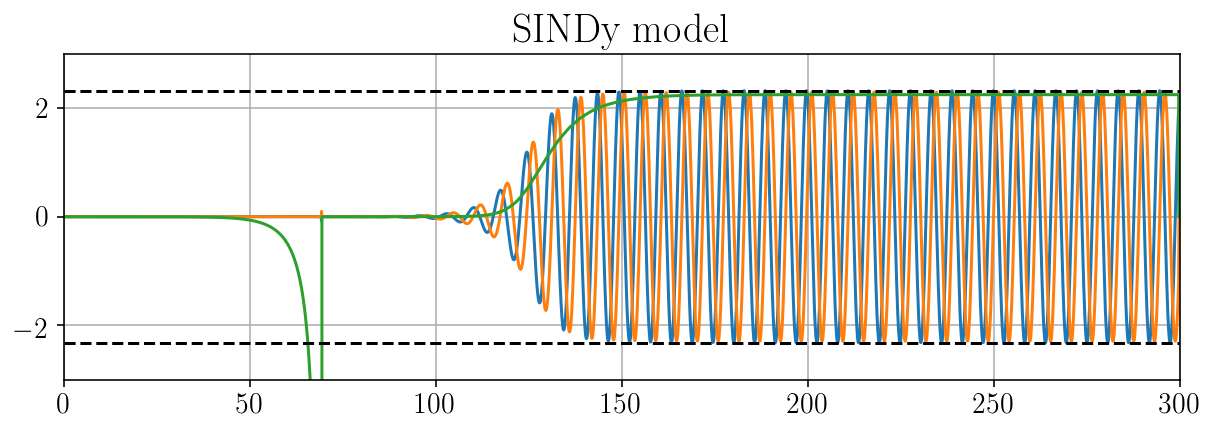

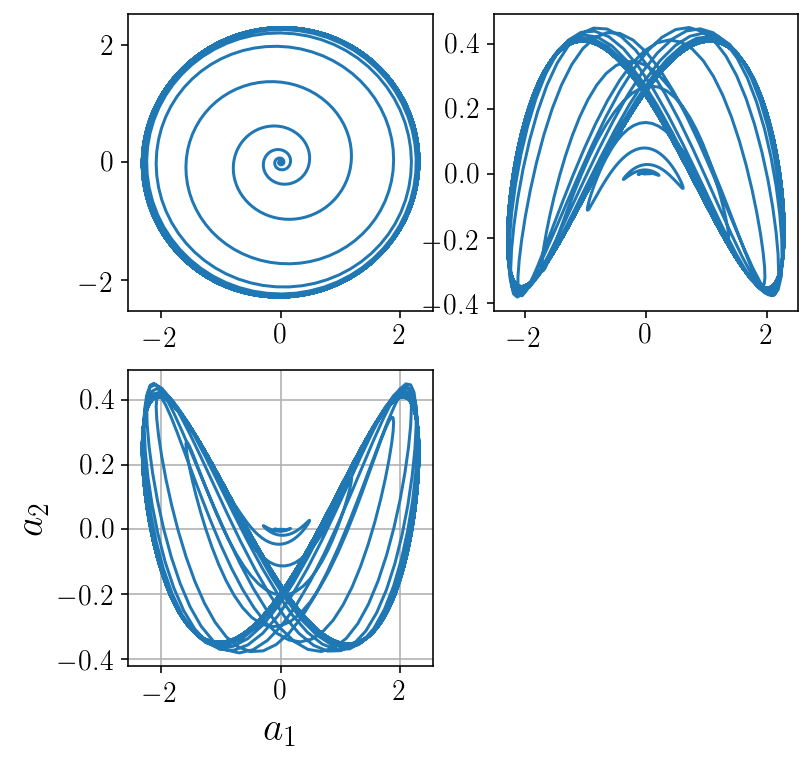

In [5]:
# Nonlinear correlations for POD reconstruction
steady_idx = t>250
threshold = 0.05
poly_order = 2
r = 3
a3 = a[:,[0, 1, -1]]
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2, 
                     lambda x, y, z:x*y*z, lambda x, y:x**2*y, lambda x:x**3]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x, 
                          lambda x, y, z:x+y+z, lambda x, y:x+y, lambda x:x+x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)
sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=1.0, 
                              max_iter=2000, tol=1e-10,
                              thresholder="l0")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a3, t=t)
model.print()
Xi = model.coefficients().T
print(Xi)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy = model.simulate(a3[300,:], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()


plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.subplot(222)
plt.plot(a[:, 1], a[:, 2])
plt.subplot(223)
plt.plot(a[:, 0], a[:, 2])
#plt.plot(a_sindy[:, 0], a_sindy[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()
plt.show()

### Try 3-mode (shift-mode) constrained quadratic SINDy model

9 (10,) (10, 27)
x0' = 0.128 x0 + -0.808 x1 + -0.054 x0x2 + -0.146 x1x2
x1' = 0.778 x0 + 0.117 x1 + 0.147 x0x2 + -0.057 x1x2
x2' = -0.129 x2 + 0.054 x0x0 + 0.057 x1x1
[[ 0.1277462   0.77754171  0.        ]
 [-0.80768308  0.11732324  0.        ]
 [-0.         -0.         -0.1291644 ]
 [-0.         -0.         -0.        ]
 [-0.05401202  0.14675284 -0.        ]
 [-0.14600446 -0.05658975 -0.        ]
 [ 0.          0.          0.05401202]
 [ 0.         -0.          0.05658975]
 [ 0.          0.         -0.        ]]


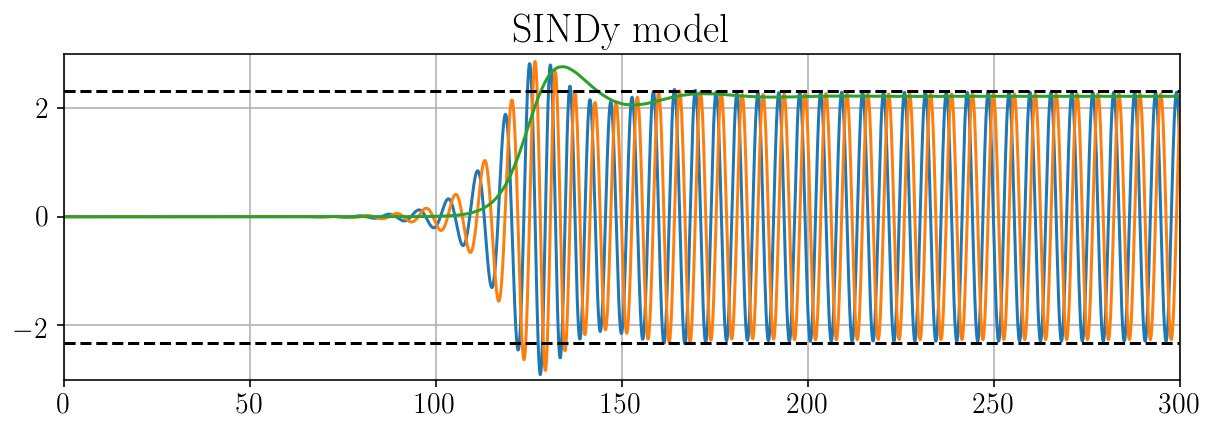

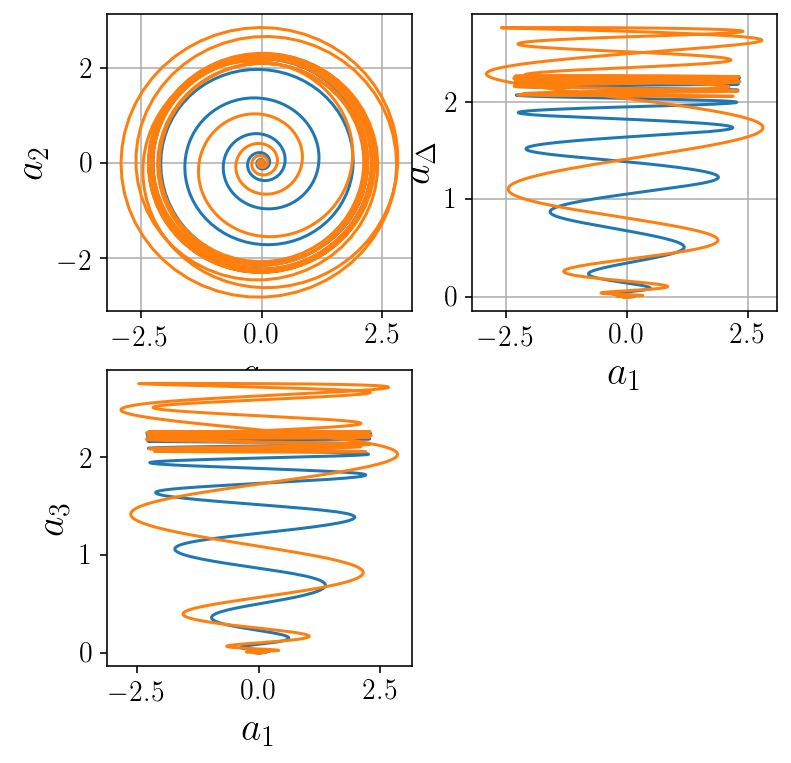

In [6]:
# Nonlinear correlations for POD reconstruction
steady_idx = t>250

## Setup hyperparameters and matrices
r = 3
Nr = int((r**2 + 3*r)/2.0)
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), r * Nr))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
    
    
threshold = 0.001
poly_order = 2
print(Nr, constraint_zeros.shape, constraint_matrix.shape)
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
#                     lambda x, y, z:x*y*z, lambda x, y:x**2*y, lambda x:x**3]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
#                          lambda x, y, z:x+y+z, lambda x, y:x+y, lambda x:x+x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

nu = 1.0
sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=nu,
                              max_iter=2000, tol=1e-10,
                              thresholder="l0",
                              constraint_lhs=constraint_matrix,
                              constraint_rhs=constraint_zeros,
                              constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a3, t=t)
model.print()
Xi = model.coefficients().T
print(Xi)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy2 = model.simulate(a3[300,:], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy2[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy2[:, 1], a_sindy2[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

# plt.subplot(224)
# plt.plot(a[:, 0], a[:, 4])
# plt.plot(a_sindy2[:, 0], a_sindy2[:, 4])
# plt.xlabel(r'$a_1$')
# plt.ylabel(r'$a_5$')
plt.grid()
plt.show()

### Try 3-mode (shift-mode) constrained quadratic SINDy model with new SINDy algo
I haven't been able to choose an $\eta$ or $\gamma$ (eigmax) that improves on the original 3-mode one, probably because this model is already stable. 

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:373: ConvergenceWarning: proxgradSR3._reduce did not converge after 2000 iterations.
  ConvergenceWarning,


x0' = 0.128 x0 + -0.808 x1 + -0.054 x0x2 + -0.146 x1x2
x1' = 0.778 x0 + 0.117 x1 + 0.147 x0x2 + -0.057 x1x2
x2' = -0.129 x2 + 0.054 x0x0 + 0.057 x1x1
[[ 0.12774389  0.77754314  0.        ]
 [-0.80768165  0.11732668  0.        ]
 [-0.         -0.         -0.12925218]
 [-0.         -0.         -0.        ]
 [-0.05401231  0.14675284 -0.        ]
 [-0.14600446 -0.05659004 -0.        ]
 [ 0.          0.          0.05407206]
 [ 0.         -0.          0.0565329 ]
 [ 0.          0.          0.        ]]
[-2.50206151e-42 -3.06066158e-43  2.03155912e+01]
As eigvals:  [-0.96721161 -1.03472291 -0.12925218]
True


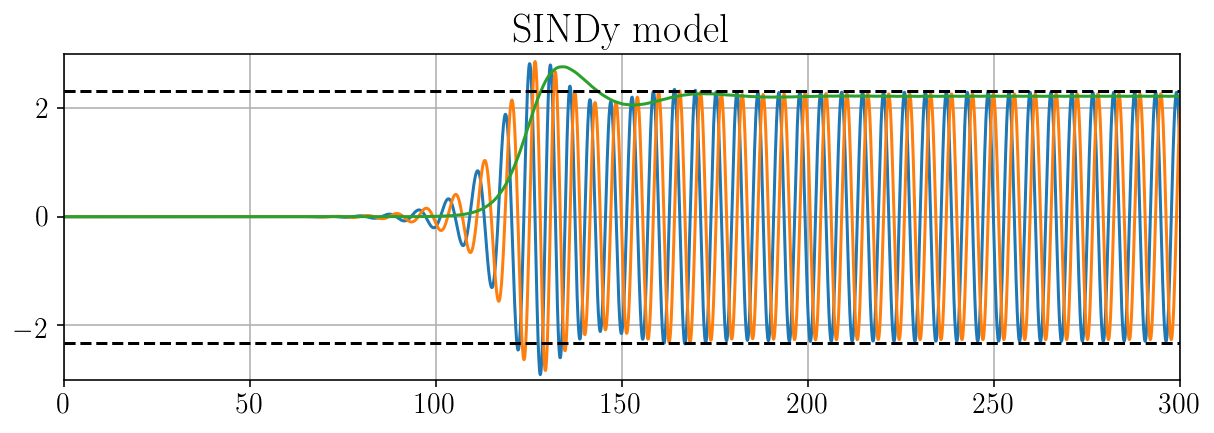

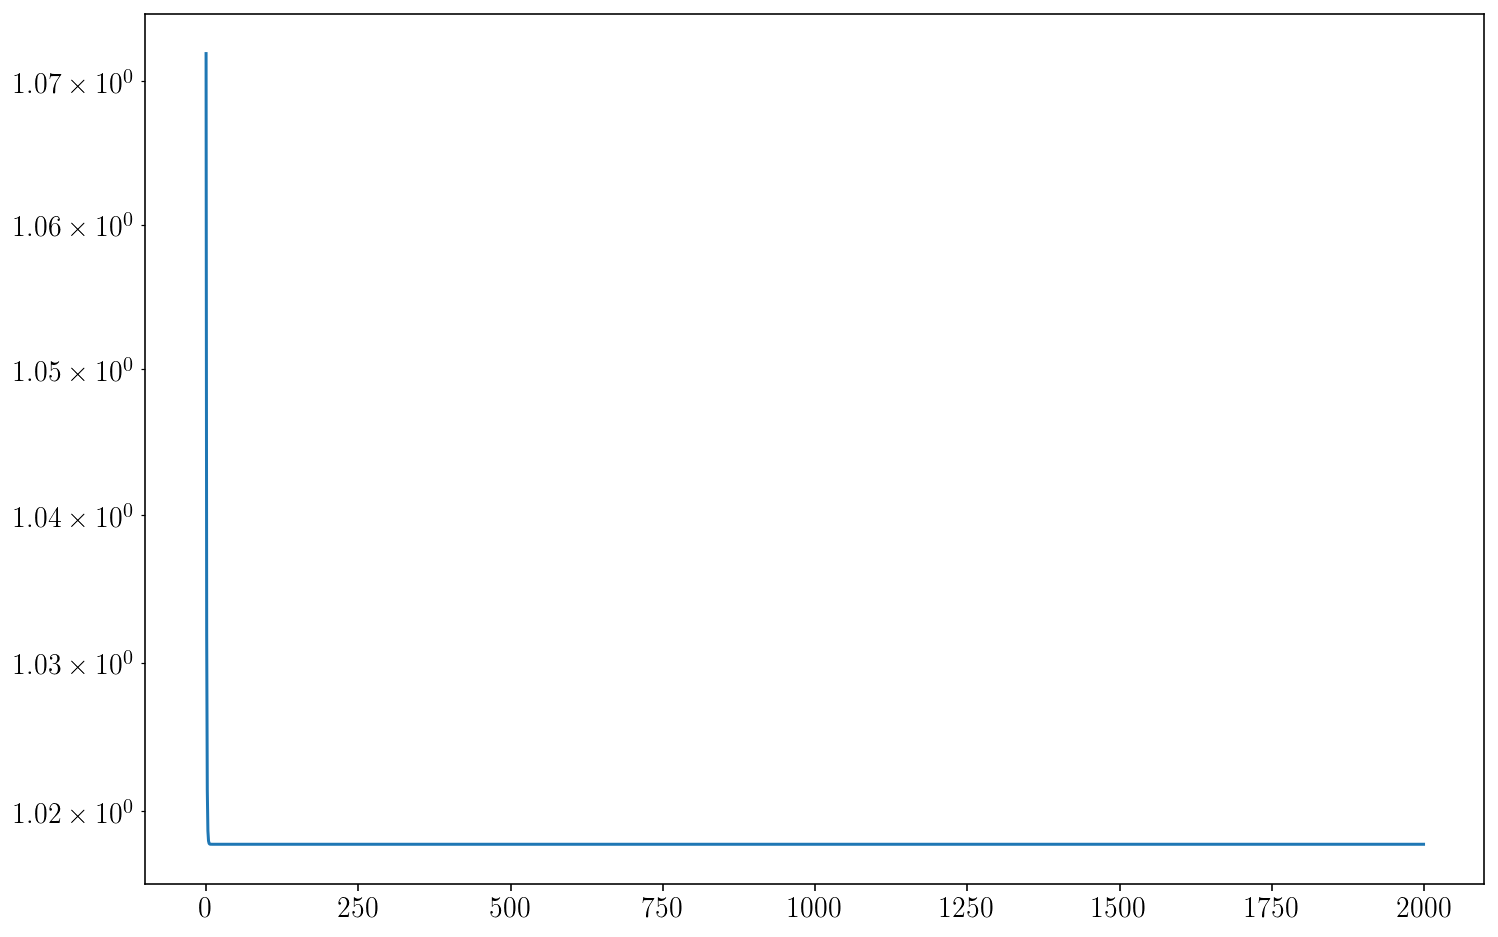

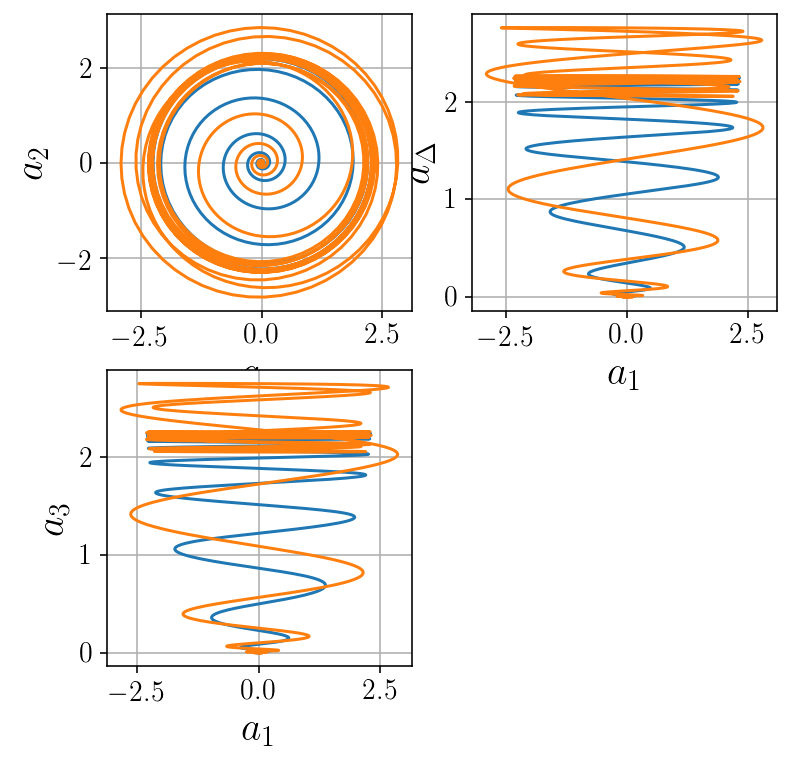

In [7]:
eta = 1.0e4
sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=2000, tol=1e-10,
                            thresholder="l0", eigmin=-1e20, eigmax=-1, 
                            alpha=0.5*min(nu,eta), beta=0.5,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a3, t=t)
model.print()
Xi = model.coefficients().T
print(Xi)
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        for k in range(r):
            mPQ[i, j, k, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m[k] #* PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i]
for i in range(r):
    for k in range(r):
        mPQ[i, i, k, Nr - r + i] = opt_m[k] #*PQ_tensor[i, i, Nr - r + i]
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy3 = model.simulate(a3[300,:], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(222)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(223)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy3[:, 1], a_sindy3[:, -1])
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

# plt.subplot(224)
# plt.plot(a[:, 0], a[:, 4])
# plt.plot(a_sindy3[:, 0], a_sindy3[:, 4])
# plt.xlabel(r'$a_1$')
# plt.ylabel(r'$a_5$')
# plt.grid()
plt.show()

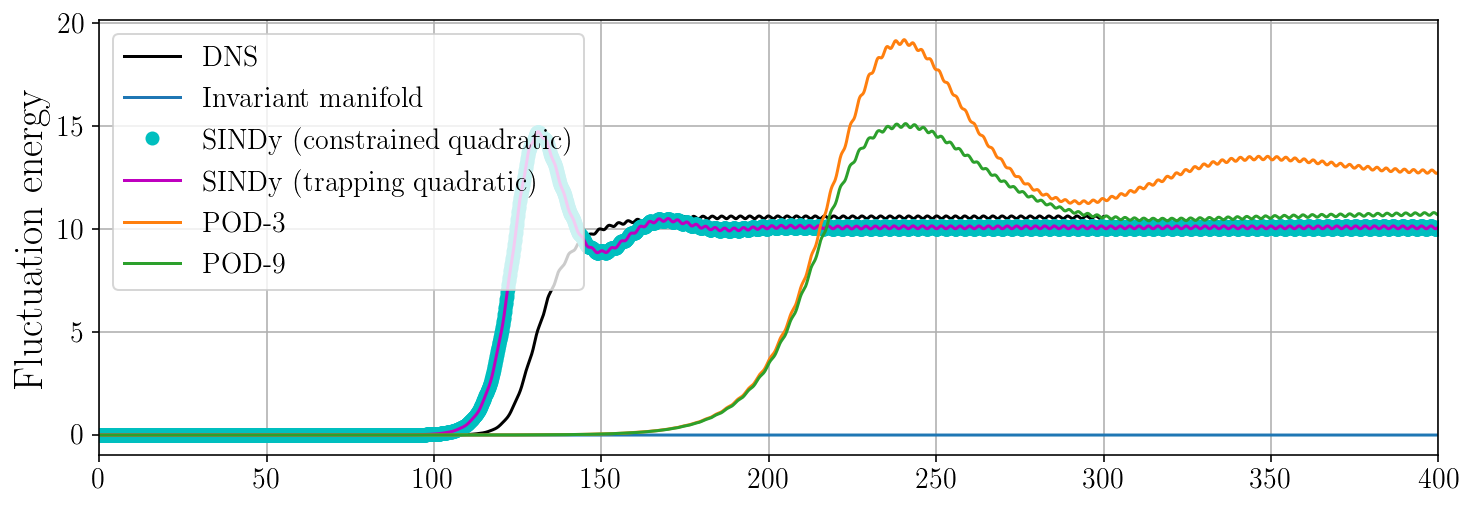

In [8]:
# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
E_sindy = np.sum(a_sindy**2, axis=1)
E_sindy2 = np.sum(a_sindy2**2, axis=1)
E_sindy3 = np.sum(a_sindy3**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
plt.plot(t_sim, E_sindy2, 'co', label=r'SINDy (constrained quadratic)')
plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.show()

### Retry constrained SINDy with 9-mode model with no thresholding

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrained_sr3.py:301: ConvergenceWarning: SR3._reduce did not converge after 20000 iterations.
  ConvergenceWarning,


x0' = 0.100 x0 + -0.819 x1 + 0.018 x2 + 0.014 x3 + -0.432 x4 + 0.157 x5 + -0.029 x6 + 0.008 x7 + -0.002 x8 + 0.002 x0x1 + -0.124 x0x2 + -0.092 x0x3 + -0.008 x0x4 + -0.001 x0x5 + 0.026 x0x6 + -0.039 x0x7 + -0.032 x0x8 + -0.048 x1x2 + 0.052 x1x3 + -0.004 x1x4 + 0.006 x1x5 + 0.052 x1x6 + 0.026 x1x7 + -0.166 x1x8 + 0.001 x2x3 + 0.561 x2x4 + -0.045 x2x5 + 0.008 x2x6 + 0.048 x2x7 + -0.003 x2x8 + 0.017 x3x4 + 0.579 x3x5 + 0.009 x3x6 + 0.024 x3x7 + -0.003 x3x8 + 0.002 x4x5 + -0.876 x4x6 + -0.961 x4x7 + 0.134 x4x8 + -0.936 x5x6 + 0.873 x5x7 + -0.081 x5x8 + 0.039 x6x7 + 0.012 x6x8 + -0.007 x7x8 + 0.001 x1x1 + -0.031 x2x2 + -0.014 x3x3 + 0.020 x4x4 + -0.008 x5x5 + -0.023 x6x6 + -0.011 x7x7
x1' = 0.818 x0 + 0.126 x1 + -0.001 x2 + -0.006 x3 + 0.213 x4 + 0.544 x5 + 0.014 x6 + -0.008 x7 + 0.004 x8 + -0.001 x0x1 + -0.102 x0x2 + -0.036 x0x3 + -0.005 x0x4 + 0.003 x0x5 + 0.104 x0x6 + -0.002 x0x7 + 0.130 x0x8 + -0.129 x1x2 + 0.062 x1x3 + -0.001 x1x4 + 0.003 x1x5 + 0.026 x1x6 + 0.125 x1x7 + -0.068 x1x8 + -

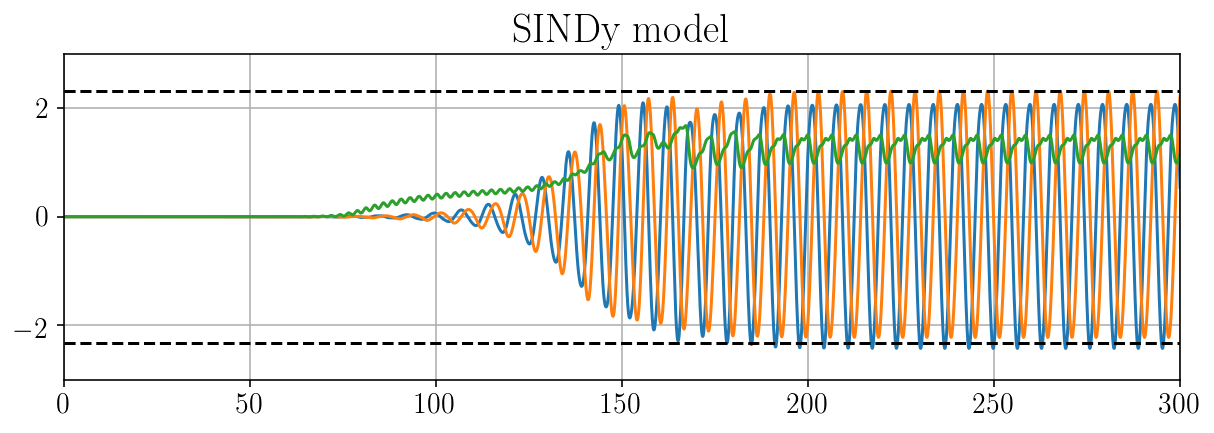

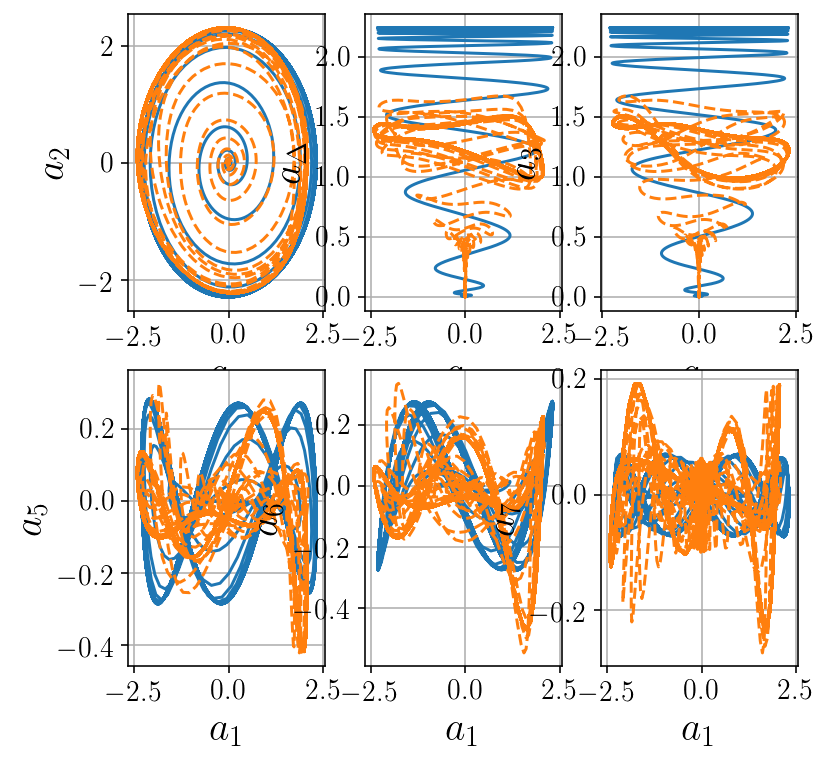

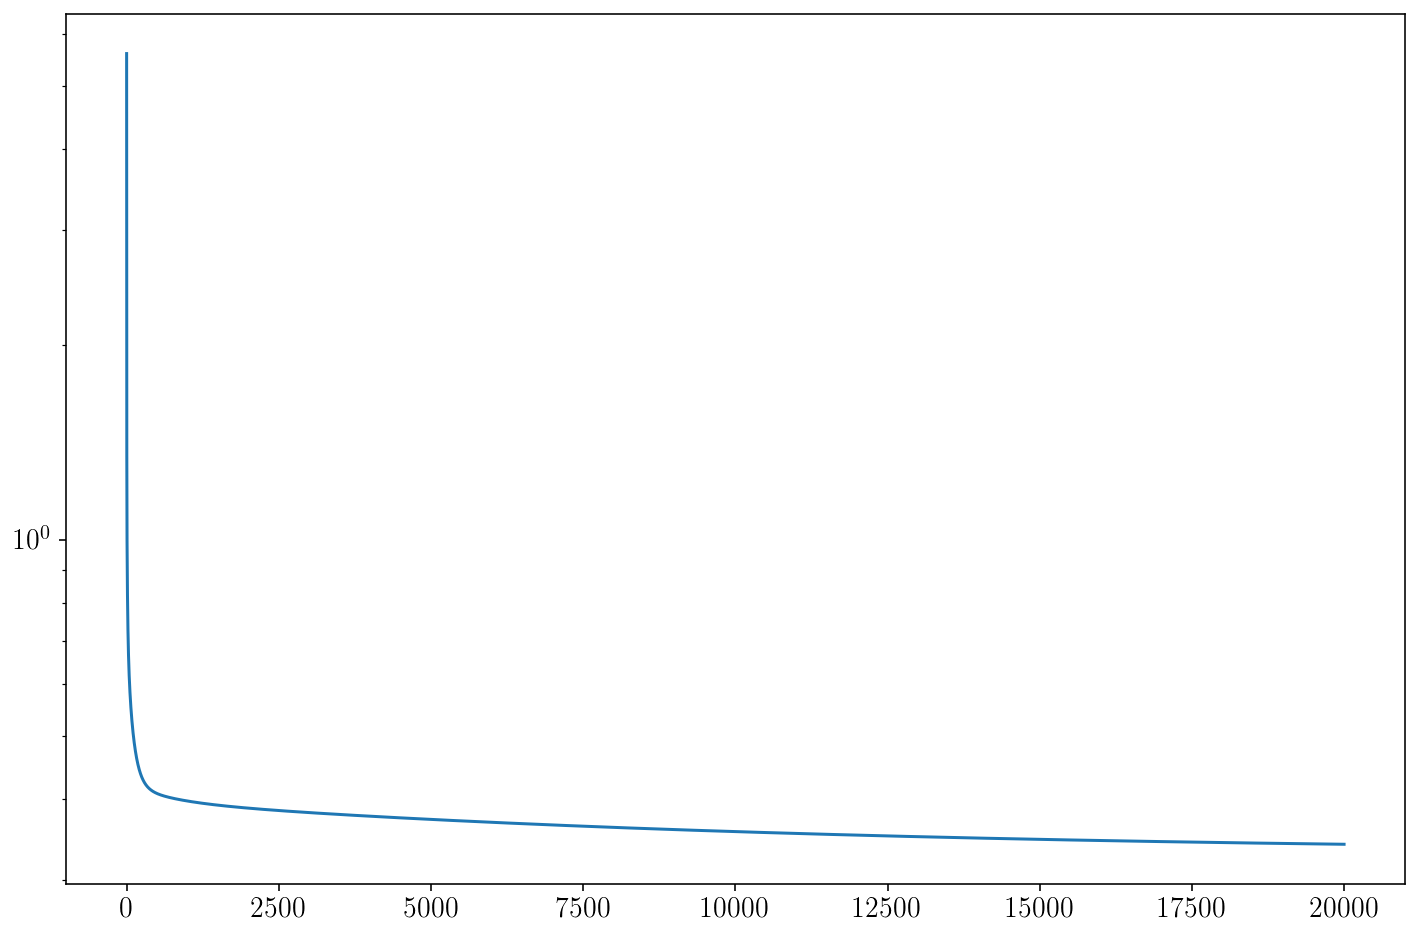

In [9]:
# Nonlinear correlations for POD reconstruction
steady_idx = t>250

## Setup hyperparameters and matrices
r = 9
Nr = int((r**2 + 3*r)/2.0)
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), r * Nr))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor= np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
    
    
threshold = 0.0
poly_order = 2
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
#                     lambda x, y, z:x*y*z, lambda x, y:x**2*y, lambda x:x**3]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
#                          lambda x, y, z:x+y+z, lambda x, y:x+y, lambda x:x+x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

nu = 1.0
sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=nu,
                              max_iter=20000, tol=1e-5,
                              thresholder="l0",
                              constraint_lhs=constraint_matrix,
                              constraint_rhs=constraint_zeros,
                              constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy2 = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy2[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy2[:, 0], a_sindy2[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy2[:, 1], a_sindy2[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy2[:, 0], a_sindy2[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()

plt.figure()
plt.semilogy(sindy_opt.objective_history)
plt.show()

### Take constrained SINDy model and search for an optimal m with simulated annealing
This is a check to see if the constrained SINDy model is stable even without the extra minimizations that our new SINDy algorithm uses. Looks like this particular model fails to meet the requirements of Theorem 1 in Schlegel et al.

In [10]:
from scipy.optimize import dual_annealing

# Get model L and Q 
Ls = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))

def obj_function(m, L_obj, Q_obj):
    As = np.zeros(L_obj.shape)
    As = L_obj - np.tensordot(m, Q_obj, axes=([0, 2]))
    eigvals, eigvecs = np.linalg.eig(As)
    return(np.sort(eigvals)[-1].real)

boundvals = np.zeros((r, 2))
boundmax = 100
boundmin = -100
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

algo_sol = dual_annealing(obj_function, bounds=boundvals, args=(Ls, Q), maxiter=5000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print(opt_m, opt_energy, opt_result)
A_identified = Ls - np.tensordot(opt_m, Q, axes=([0, 2]))
print(A_identified)
eigvals, eigvecs = np.linalg.eig(A_identified)
print(np.sort(eigvals), np.all(eigvals < 0.0))

[ 0.02990302 -0.01117186  0.0151572  -0.08072122 -0.01103906  0.02700695
  0.02448665  0.00520904  1.82445171] 0.09755088987386482 ['Maximum number of iteration reached']
[[ 4.79515817e-02 -3.21388519e-02  1.86396638e-03  3.80621031e-04
  -8.12724209e-02 -2.07838108e-02 -1.87730553e-02  9.22255038e-03
   1.41520426e-03]
 [-3.21388519e-02 -2.55903259e-03  6.26576375e-03 -7.58619680e-03
   1.24706648e-02  1.19752304e-01 -4.60388629e-03 -1.00956623e-02
   3.57786234e-03]
 [ 1.86396638e-03  6.26576375e-03  8.82369914e-03  2.00637262e-02
   1.44116079e-02 -1.76148495e-02 -6.03317679e-01 -8.19529393e-03
  -7.25518586e-02]
 [ 3.80621031e-04 -7.58619680e-03  2.00637262e-02  2.39322264e-02
   1.76741642e-02  4.06301726e-03  7.08162574e-02  6.19617380e-01
   2.58255469e-02]
 [-8.12724209e-02  1.24706648e-02  1.44116079e-02  1.76741642e-02
  -2.43172546e-01 -2.34044072e-02 -4.87689341e-02 -1.18926795e-02
   2.37451302e-02]
 [-2.07838108e-02  1.19752304e-01 -1.76148495e-02  4.06301726e-03
  -2.340

In [11]:
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
Qsum = np.sum(Q + np.transpose(Q, [2, 1, 0]) + np.transpose(Q, [0, 2, 1])) 
print(Qsum)

8.258489878381921e-14


### Retry new constrained SINDy with 9-mode model with no threshold

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/proxgrad_bounded_sr3.py:373: ConvergenceWarning: proxgradSR3._reduce did not converge after 1000 iterations.
  ConvergenceWarning,


x0' = -0.014 x0 + -0.895 x1 + -0.018 x2 + -0.009 x3 + -0.040 x4 + 0.365 x5 + 0.055 x6 + 0.063 x7 + 0.007 x8 + -0.003 x0x1 + -0.134 x0x3 + 0.007 x0x4 + -0.002 x0x5 + -0.146 x0x6 + 0.065 x0x7 + -0.003 x0x8 + -0.130 x1x2 + -0.083 x1x3 + 0.003 x1x4 + -0.011 x1x6 + -0.093 x1x7 + -0.100 x1x8 + -0.004 x2x3 + 0.360 x2x4 + -0.551 x2x5 + 0.130 x2x6 + -0.081 x2x7 + -0.006 x2x8 + 0.507 x3x4 + 0.384 x3x5 + -0.074 x3x6 + -0.092 x3x7 + 0.015 x3x8 + -0.028 x4x5 + -1.127 x4x6 + 0.459 x4x7 + -0.028 x4x8 + 0.490 x5x6 + 1.166 x5x7 + -0.120 x5x8 + -0.020 x6x8 + -0.001 x7x8 + -0.004 x1x1 + -0.007 x2x2 + 0.096 x4x4 + 0.090 x5x5 + -1.428 x6x6 + -1.396 x7x7 + -0.001 x8x8
x1' = 0.800 x0 + 0.109 x1 + -0.046 x2 + 0.061 x3 + 0.453 x4 + 0.475 x5 + 0.186 x6 + -0.001 x7 + 0.005 x8 + 0.004 x0x1 + 0.011 x0x2 + -0.098 x0x3 + -0.022 x0x4 + -0.013 x0x5 + 0.029 x0x6 + -0.173 x0x7 + 0.117 x0x8 + -0.165 x1x2 + -0.001 x1x3 + -0.016 x1x4 + 0.015 x1x5 + 0.104 x1x6 + 0.040 x1x7 + -0.049 x1x8 + 0.003 x2x3 + -0.223 x2x4 + -0.382 x

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


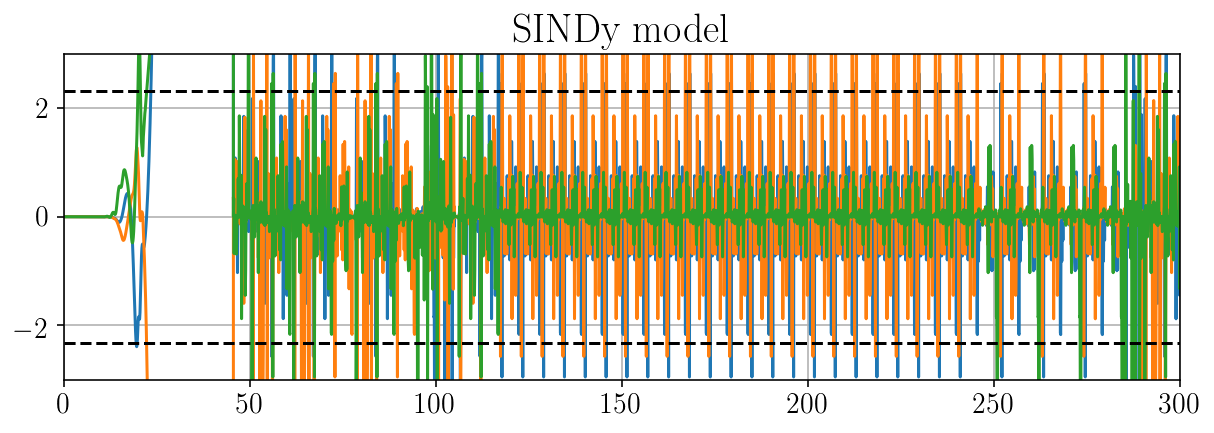

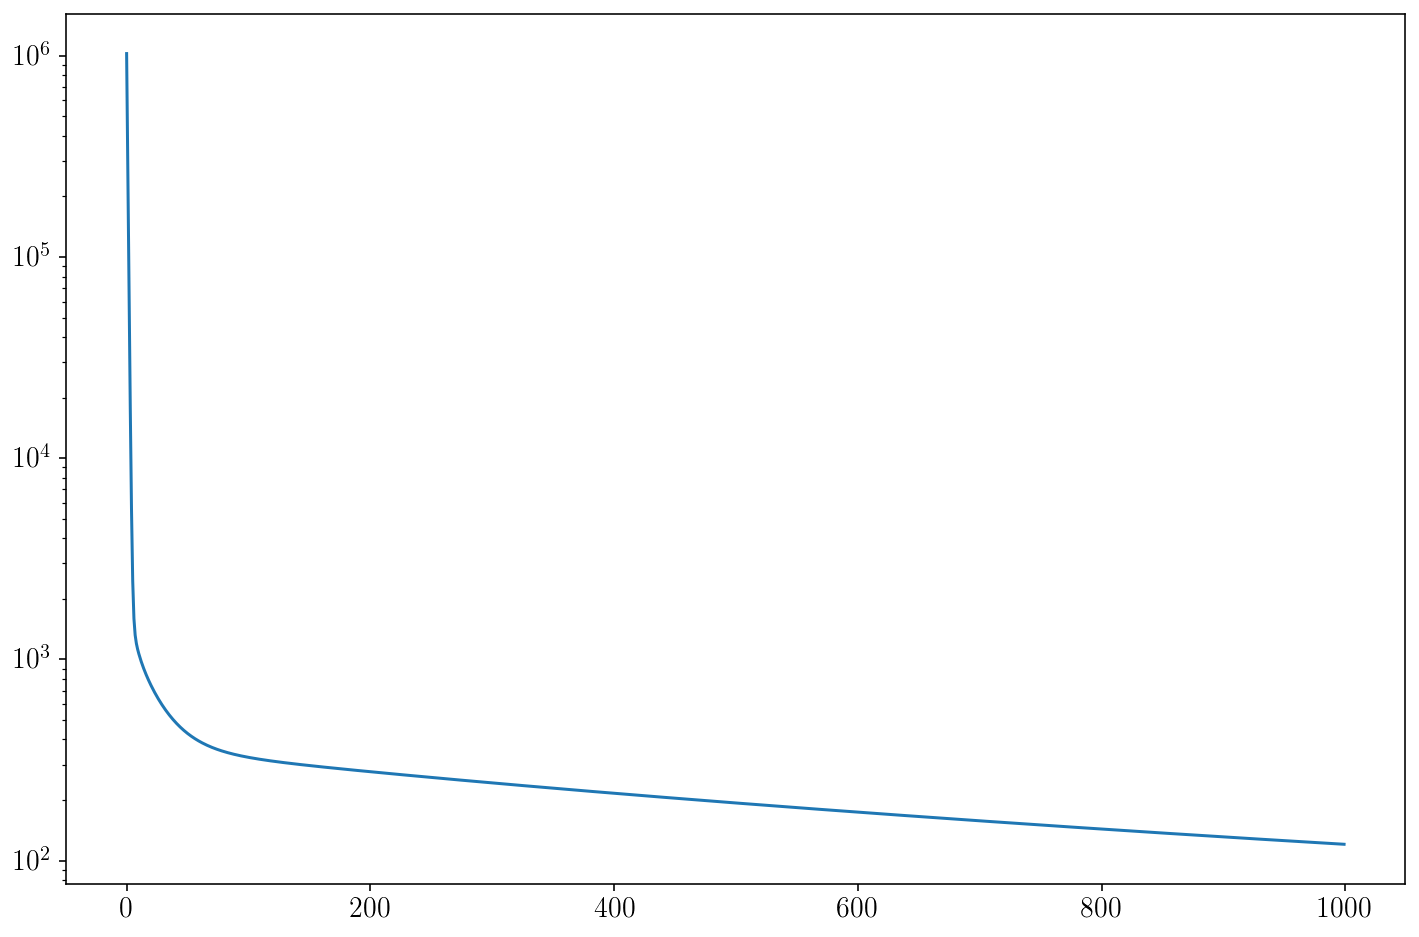

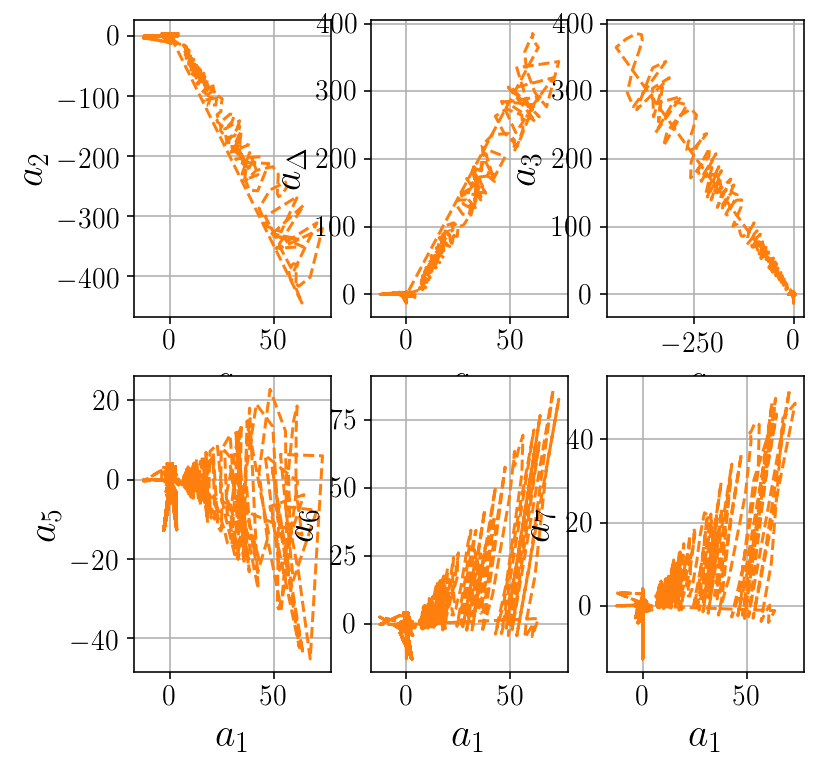

/media/akaptano/HITSI-Work/pysindy/pysindy/pysindy.py:339: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  "Control variables u were ignored because control variables were"
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


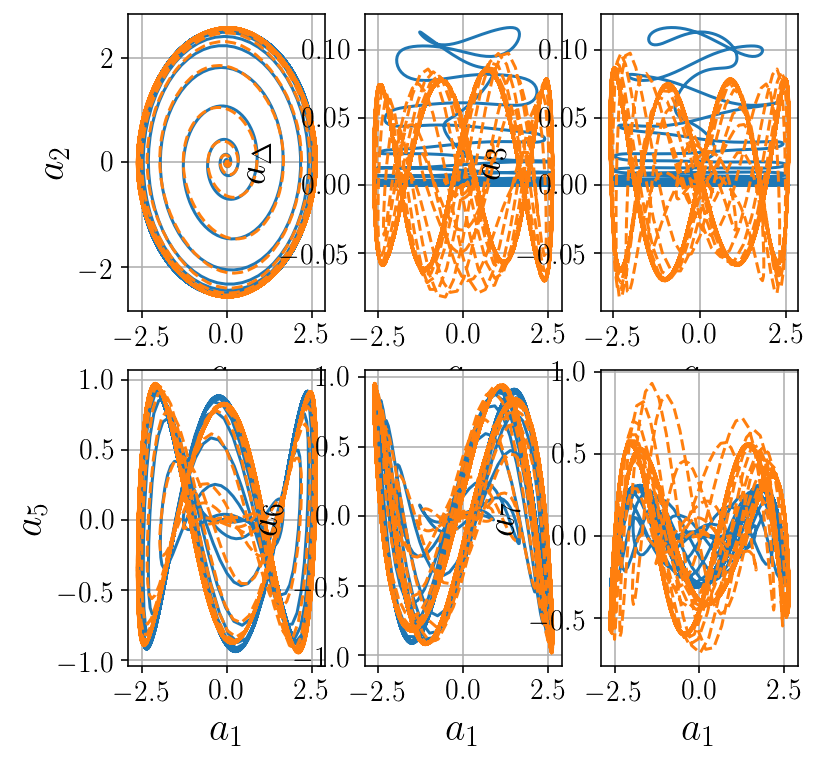

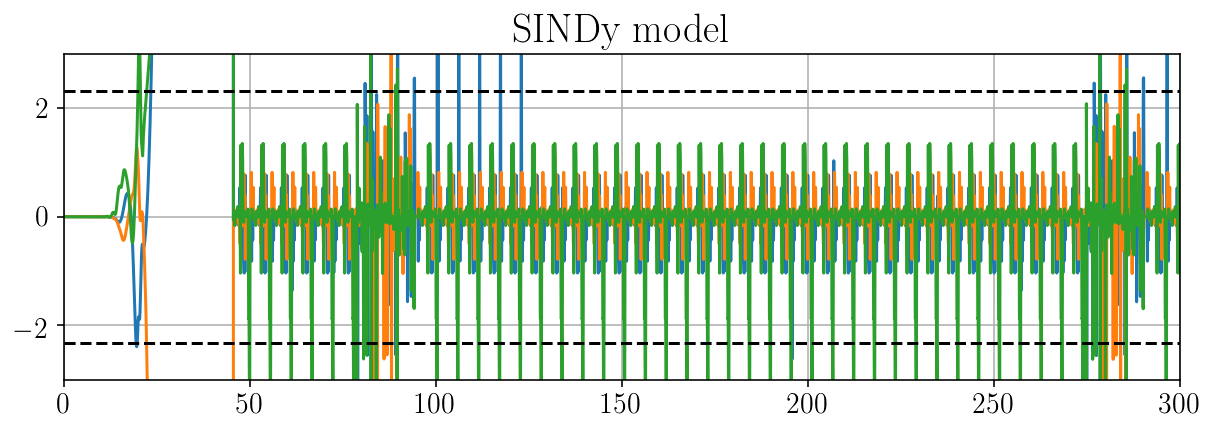

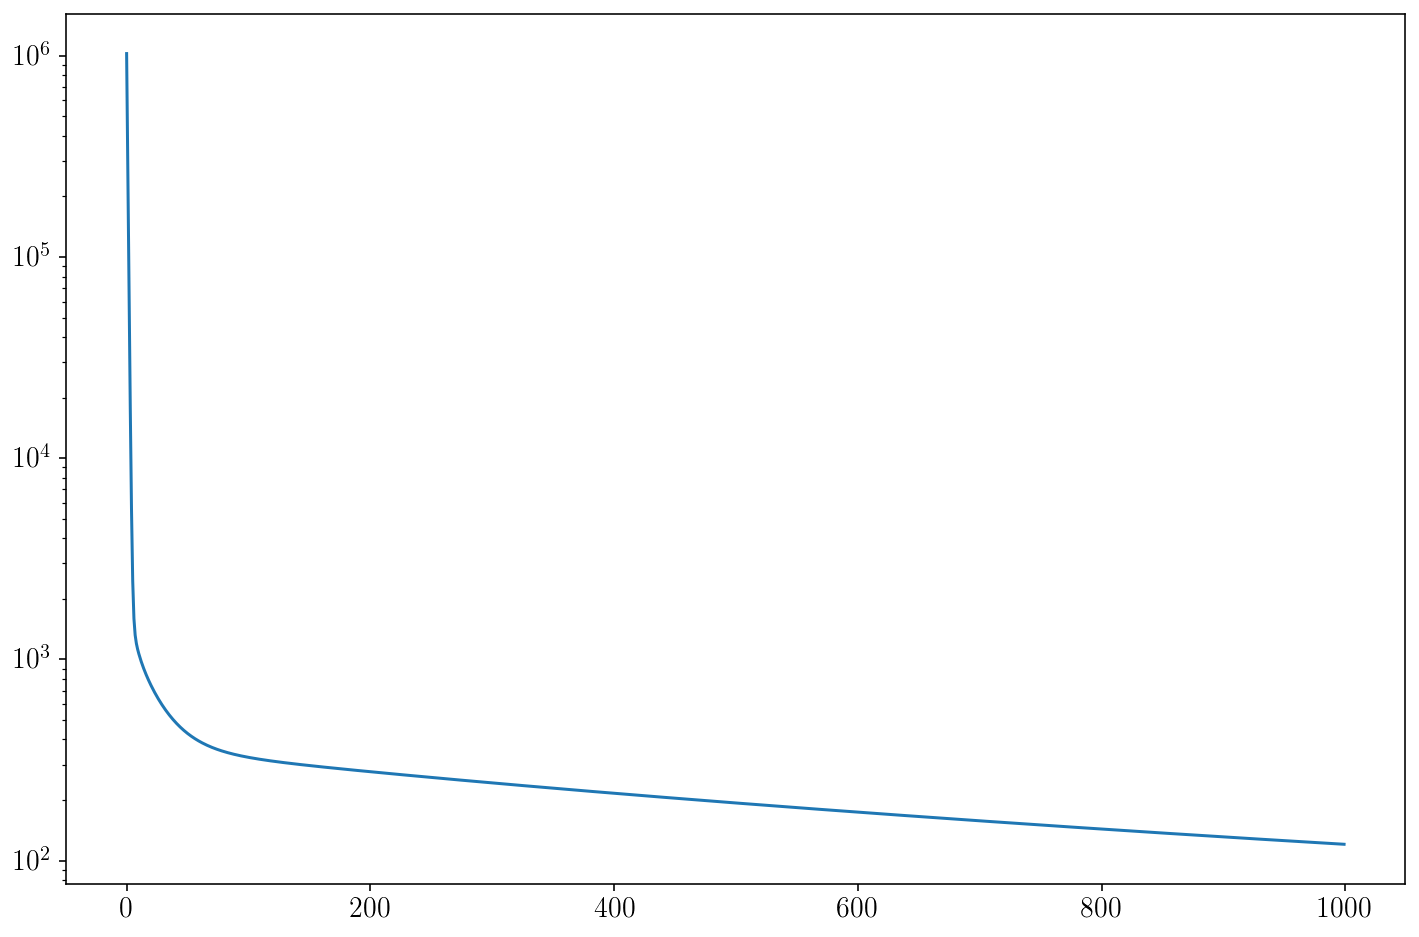

In [12]:
# Reproduces constrained sindy when eta is very large
eta = 1e3
nu = 1e-5
sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=1000, tol=1e-10,
                            thresholder="l0", eigmin=-1e20, eigmax=-1, 
                            alpha=0.5*min(nu,eta), beta=0.5*eta,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy3 = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy3[:, 0], a_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy3[:, 1], a_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy3[:, 0], a_sindy3[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

a_dot = model.differentiate(a[:, :r], t)
a_dot_sindy3 = model.predict(a[:, :r], t)
a_sindy3 = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.plot(a_dot_sindy3[:, 0], a_dot_sindy3[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.plot(a_dot_sindy3[:, 0], a_dot_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a_dot[:, 1], a_dot[:, -1])
plt.plot(a_dot_sindy3[:, 1], a_dot_sindy3[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a_dot[:, 0], a_dot[:, 4])
plt.plot(a_dot_sindy3[:, 0], a_dot_sindy3[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a_dot[:, 0], a_dot[:, 5])
plt.plot(a_dot_sindy3[:, 0], a_dot_sindy3[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a_dot[:, 0], a_dot[:, 6])
plt.plot(a_dot_sindy3[:, 0], a_dot_sindy3[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)
plt.show()

In [13]:
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
Qsum = np.sum(Q + np.transpose(Q, [2, 1, 0]) + np.transpose(Q, [0, 2, 1])) 
print(Qsum)
print(np.dot(constraint_matrix, Xi.flatten()))

-2.8595914103835022e-08
[-8.27513046e-09  4.29656777e-09 -1.64975084e-08  5.31959781e-09
 -1.68558532e-10 -4.94749916e-10  2.13229182e-10  2.90456225e-10
  1.08029384e-08 -1.20150767e-08 -1.11625316e-08 -1.09154530e-08
 -1.19729023e-09 -2.27982637e-09 -9.51416057e-10 -1.00406861e-09
 -9.51355755e-09  4.45520888e-09  3.97057145e-09  1.23436984e-10
 -4.71047183e-10  2.12450058e-11 -7.68819453e-11  2.18389830e-09
 -1.74050517e-08 -2.31559522e-09 -2.35558889e-09 -1.40936118e-09
 -9.03156883e-10 -1.39371319e-08  5.51986123e-10  6.00286820e-10
 -3.06316084e-11  5.23457278e-10  3.40065037e-09 -3.57320472e-10
 -2.14284493e-10 -8.54740723e-11 -1.60389301e-09 -3.13305271e-10
 -3.96267796e-10 -3.02349804e-09  2.65712063e-10  3.30642609e-09
  5.94272254e-09  2.93019401e-09 -1.31697700e-08 -1.87969459e-08
  4.72737385e-09  6.14602127e-09  8.21305157e-09 -7.15538956e-11
 -5.53627241e-10 -4.57650993e-09 -9.20518420e-10 -4.64012105e-09
 -2.39750638e-09 -2.31323501e-09 -2.85746243e-09 -4.63320687e-10
 

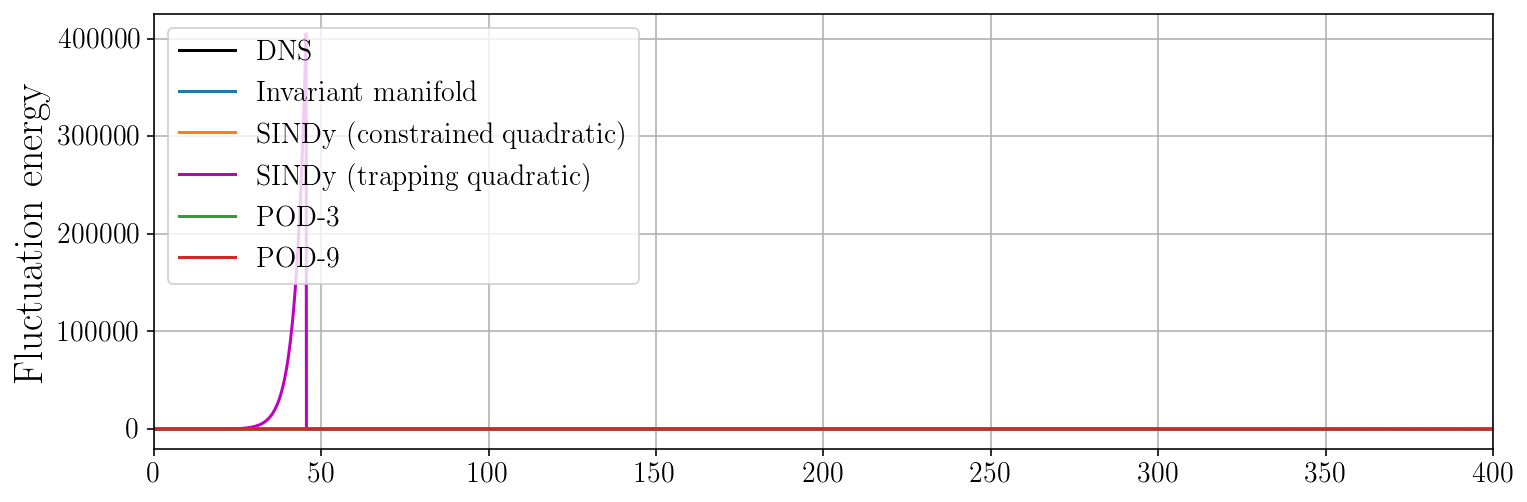

In [14]:
# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
E_sindy = np.sum(a_sindy**2, axis=1)
E_sindy2 = np.sum(a_sindy2**2, axis=1)
E_sindy3 = np.sum(a_sindy3**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
plt.plot(t_sim, E_sindy2, label=r'SINDy (constrained quadratic)')
plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.show()

In [15]:
## Setup hyperparameters and matrices
r = 9
Nr = int((r**2 + 3*r)/2.0)
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), r * Nr))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor= np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)

85.76777744703577 2.764848872095269 0.00821537944074753
6.879174727642469 0.8212095122360611 6.1365932142041455
3.178158040762039 0.49369599790681973 3.8536390451785603
1.9421379821067506 0.3753703784916263 2.5694996706019233
1.3935727674967766 0.31018984058831345 1.8606924155094786
1.114025237140913 0.26674915331570204 1.4593418740530715
0.956727971322179 0.23397433109331967 1.2197498783100207
0.859551984747222 0.20744868924290463 1.0653304590066566
0.7935441076675265 0.18486383662716965 0.9569419893003516
0.7446189326748083 0.1652211403831201 0.8745768620054238
0.7057433614152244 0.14803283657877914 0.807955979435072
0.6733162452289745 0.13294752892514475 0.7516870485626936
0.6453942653001821 0.11967972921447687 0.7028351363306091
0.6208896109015151 0.10806810711512416 0.6596865387101687
0.5991521209306235 0.09794770631650851 0.6211503512700649
0.5797344312433004 0.08915465530059893 0.5864817837141031
0.5623028375947117 0.08152639902582498 0.5551296516066241
0.5465885592015729 0.0749

0.2672815744207995 0.013465116101362402 0.14383591180551694
0.2668826557051772 0.013423318931314196 0.143645466144045
0.2664874430894151 0.013381861864143328 0.1434578188432037
0.2660958772019314 0.013340740047575227 0.14327291539288647
0.2657079001449666 0.013299948757682905 0.14309070259039522
0.2653234554442566 0.013259483393741178 0.1429111284998522
0.26494248800112197 0.013219339473262415 0.14273414241310606
0.264564944046632 0.013179512627329856 0.14255969481218694
0.26419077109717115 0.013139998596141239 0.14238773733378854
0.2638199179122888 0.01310079322474202 0.14221822273485082
0.2634523344539529 0.013061892459001816 0.14205110485975758
0.2630879718477299 0.01302329234175452 0.14188633860865926
0.2627267823451369 0.012984989009140756 0.14172387990736618
0.26236871928787225 0.012946978687074524 0.1415636856781293
0.2620137370732386 0.012909257687980309 0.1414057138116461
0.2616617911208772 0.012871822407551135 0.141249923140327
0.26131283784112436 0.012834669321757539 0.14109

0.23127180521808977 0.009540741487177486 0.13069863979936472
0.2311263351999295 0.009524609997961633 0.13065985083696344
0.23098161355488583 0.00950856321392755 0.1306213453042934
0.23083763450190325 0.009492600528550641 0.13058311992930988
0.23069439232051311 0.009476721340851087 0.13054517148890774
0.2305518813500147 0.009460925055316817 0.13050749680798227
0.2304100959885514 0.009445211081853037 0.13047009275871996
0.2302690306924443 0.009429578835708791 0.13043295625957677
0.23012867997525666 0.009414027737421584 0.13039608427464483
0.2299890384071564 0.009398557212759891 0.13035947381263016
0.2298501006139465 0.009383166692657574 0.13032312192631917
0.22971186127657595 0.009367855613155146 0.1302870257115203
0.22957431513010684 0.009352623415344624 0.13025118230660537
0.22943745696319337 0.009337469545319868 0.1302155888915084
0.22930128161731916 0.00932239345409452 0.1301802426871242
0.22916578398595122 0.009307394597587067 0.1301451409546432
0.22903095901413445 0.009292472436535

0.2158100054888215 0.007849905102346639 0.126958246919119
0.21573319472871985 0.007841710514572376 0.12694111187822196
0.21565666895151087 0.007833549375727803 0.1269240495703051
0.2155804265230588 0.00782542149602534 0.12690705944957806
0.21550446582124821 0.007817326687009827 0.12689014097559193
0.21542878523575718 0.007809264761545486 0.12687329361327773
0.21535338316791536 0.007801235533795461 0.12685651683292534
0.21527825803075587 0.007793238819227096 0.12683981010995132
0.215203408248701 0.007785274434571007 0.12682317292508755
0.21512883225774887 0.007777342197855155 0.12680660476395506
0.2150545285051626 0.007769441928359107 0.12679010511728903
0.21498049544928224 0.007761573446604894 0.1267736734809134
0.21490673155971818 0.0077537365743752425 0.12675730935541574
0.2148332353170248 0.007745931134670435 0.12674101224630702
0.2147600052126286 0.007738156951726213 0.12672478166392995
0.21468703974885545 0.007730413850961501 0.12670861712331666
0.21461433743875818 0.0077227016590

0.20676399087404373 0.006911476450611168 0.12498072875302595
0.2067166075116051 0.006906736032944822 0.12497045470528889
0.20666935558927382 0.006902010970191065 0.12496020858071968
0.20662223450050307 0.006897301189804234 0.1249499902291823
0.20657524364229798 0.0068926066196470775 0.12493979950174887
0.20652838241525756 0.0068879271880187415 0.12492963625060549
0.2064816502235935 0.006883262823620259 0.12491950032902398
0.20643504647500466 0.00687861345559037 0.12490939159141398
0.20638857058081853 0.006873979013474099 0.12489930989316607
0.20634222195582191 0.006869359427222194 0.1248892550908003
0.20629600001824883 0.0068647546271928 0.1248792270419176
0.20624990418984968 0.006860164544165392 0.12486922560511785
0.20620393389573716 0.006855589109314433 0.12485925064009051
0.20615808856442136 0.006851028254206909 0.12484930200759244
0.20611236762787238 0.006846481910822607 0.12483937956929889
0.206066770521382 0.006841950011521759 0.12482948318795388
0.20602129668348398 0.0068374324

0.20125165373191328 0.006376551623082472 0.12377559079084051
0.20121792414342304 0.006373391968814147 0.12376811790913132
0.20118426795469418 0.006370240697242369 0.12376065965390197
0.20115068488409657 0.006367097774465185 0.1237532159660947
0.2011171746515339 0.006363963166750736 0.12374578678691427
0.20108373697821685 0.006360836840531549 0.12373837205806959
0.20105037158683078 0.006357718762430859 0.12373097172154103
0.20101707820147754 0.006354608899235781 0.12372358571969445
0.2009838565477276 0.006351507217902695 0.12371621399514993
0.20095070635245166 0.006348413685551785 0.1237088564909884
0.2009176273439643 0.0063453282694817745 0.12370151315057865
0.20088461925200138 0.006342250937149577 0.12369418391758655
0.20085168180754964 0.006339181656179695 0.12368686873614436
0.20081881474313987 0.00633612039437279 0.12367956755052514
0.2007860177924607 0.006333067119680979 0.1236722803055408
0.20075329069072073 0.0063300218002296915 0.12366500694616293
0.20072063317439867 0.00632698

0.19685671818557954 0.005978382966458504 0.12278567875287784
0.19683154094008493 0.005976184953628078 0.12277990188764193
0.19680640695298252 0.005973991707094882 0.12277413363673656
0.19678131608669158 0.005971803210464351 0.12276837397415118
0.19675626820430225 0.0059696194474171535 0.12276262287391163
0.19673126316933043 0.005967440401731314 0.12275688031032204
0.1967063008460765 0.005965266057224557 0.12275114625765204
0.196681381099308 0.0059630963978189325 0.12274542069038344
0.19665650379445665 0.0059609314074772855 0.12273970358306824
0.19663166879741759 0.0059587710702591135 0.12273399491048287
0.19660687597481422 0.005956615370280243 0.12272829464739637
0.19658212519371113 0.005954464291733998 0.12272260276881836
0.19655741632187132 0.005952317818871476 0.12271691924975373
0.19653274922752667 0.005950175936036162 0.1227112440654415
0.19650812377958887 0.005948038627621182 0.12270557719111265
0.19648353984741423 0.00594590587809839 0.1226999186022318
0.196458997300947 0.005943

0.19373979524142504 0.005714017527537764 0.12206029734985907
0.19371950409708258 0.005712348910835121 0.12205550740082784
0.1936992417536797 0.005710683353018784 0.12205072338963965
0.1936790081327599 0.005709020844936751 0.12204594530209177
0.19365880315617662 0.0057073613774736385 0.12204117312403574
0.19363862674610383 0.005705704941551181 0.12203640684132934
0.19361847882507577 0.00570405152810945 0.12203164643985381
0.19359835931582925 0.005702401128149307 0.1220268919056073
0.19357826814138795 0.005700753732693922 0.12202214322465889
0.19355820522510173 0.005699109332800355 0.12201740038309149
0.1935381704906641 0.0056974679195691815 0.12201266336700312
0.1935181638619118 0.00569582948412232 0.12200793216266634
0.19349818526316315 0.005694194017634534 0.12200320675622879
0.19347823461879454 0.005692561511298951 0.12199848713410763
0.19345831185367662 0.005690931956348784 0.12199377328257485
0.19343841689280028 0.005689305344068046 0.12198906518809093
0.19341854966155392 0.0056876

0.19096331767273267 0.005492208170705205 0.1213972589287707
0.19094662928104258 0.0054909150050497894 0.12139323060336227
0.1909299605574975 0.005489623844548929 0.12138920656461497
0.1909133114561508 0.005488334683977016 0.12138518680418924
0.19089668193119164 0.00548704751811336 0.12138117131379911
0.1908800719369576 0.005485762341778142 0.12137716008516354
0.19086348142793014 0.00548447914979859 0.12137315311004883
0.19084691035874957 0.005483197937024278 0.12136915038022152
0.19083035868417886 0.005481918698302382 0.12136515188753476
0.19081382635919816 0.005480641428534584 0.12136115762375627
0.1907973133388287 0.005479366122605479 0.12135716758081916
0.190780819578268 0.005478092775436153 0.12135318175063667
0.19076434503289355 0.0054768213819612445 0.12134920012511212
0.19074788965829528 0.00547555193713015 0.12134522269612429
0.19073145341011266 0.005474284435915325 0.12134124945564904
0.19071503624411335 0.005473018873299582 0.12133728039572401
0.190698638116276 0.005471755244

0.18879982081172858 0.005328584671161069 0.12087164329276566
0.1887854978509455 0.005327528440380726 0.1208681444947416
0.18877118935313536 0.005326473629827148 0.12086464903329242
0.18875689528857356 0.005325420236188872 0.12086115690287781
0.1887426156275302 0.005324368256197529 0.12085766809804331
0.18872835034040913 0.005323317686552244 0.120854182613332
0.188714099397772 0.005322268523989915 0.12085070044321669
0.1886998627700922 0.005321220765259099 0.12084722158233725
0.1886856404281076 0.005320174407113013 0.1208437460251996
0.18867143234258243 0.005319129446300829 0.12084027376637803
0.1886572384843082 0.005318085879605108 0.12083680480051172
0.18864305882425228 0.00531704370380264 0.1208333391221649
0.1886288933333143 0.0053160029156898644 0.12082987672606346
0.18861474198271894 0.00531496351205433 0.12082641760672473
0.18860060474357293 0.0053139254897270494 0.12082296175885499
0.18858648158711683 0.005312888845510732 0.12081950917714505
0.18857237248473563 0.005311853576248

0.18697354192476395 0.005196748649094887 0.12042436330743554
0.1869609443718121 0.00519585899574593 0.12042127315525748
0.18694835791622133 0.005194970393785152 0.12041818570740144
0.18693578253754142 0.0051940828410154795 0.12041510095997747
0.1869232182154802 0.0051931963352301784 0.1204120189090373
0.186910664929701 0.005192310874228343 0.12040893955072299
0.18689812265988875 0.005191426455830492 0.12040586288120866
0.18688559138591368 0.005190543077851491 0.12040278889655331
0.18687307108769544 0.0051896607381090795 0.12039971759283434
0.18686056174505167 0.00518877943443772 0.12039664896627988
0.18684806333793347 0.005187899164674728 0.12039358301306408
0.18683557584638968 0.005187019926649683 0.12039051972930631
0.18682309925049295 0.005186141718225139 0.12038745911117502
0.18681063353034638 0.00518526453724352 0.12038440115485793
0.18679817866612491 0.00518438838156536 0.12038134585654929
0.18678573463803064 0.005183513249061386 0.12037829321245976
0.18677330142637322 0.00518263

0.18534319520702086 0.005083814969339839 0.12002468472655957
0.18533194805328052 0.005083051112416734 0.12002193208725973
0.18532070963398528 0.005082288054175722 0.1200191816905505
0.18530947993472413 0.0050815257930784015 0.12001643353348125
0.18529825894092863 0.005080764327605453 0.12001368761328891
0.18528704663830983 0.00508000365623696 0.12001094392697355
0.1852758430124286 0.005079243777452632 0.12000820247171587
0.1852646480490321 0.005078484689733097 0.12000546324457738
0.18525346173369278 0.005077726391584377 0.12000272624279165
0.1852422840522106 0.005076968881491604 0.11999999146344785
0.1852311149903335 0.005076212157963155 0.11999725890369205
0.18521995453389406 0.005075456219486636 0.11999452856064648
0.18520880266869902 0.0050747010645795 0.11999180043149517
0.18519765938062202 0.005073946691743781 0.11998907451339587
0.18518652465550905 0.005073193099507226 0.11998635080355385
0.1851753984793507 0.005072440286365927 0.11998362929910313
0.18516428083813774 0.0050716882

0.18381715749652047 0.004982023100198609 0.11965253603501369
0.18380702729054949 0.004981359615923541 0.11965007725128522
0.18379690405534066 0.004980696746271145 0.1196476203488992
0.18378678778038865 0.0049800344901580786 0.11964516532571909
0.18377667845534384 0.004979372846524654 0.11964271217947994
0.1837665760697242 0.0049787118142975645 0.11964026090807009
0.18375648061320476 0.004978051392400069 0.119637811509263
0.18374639207548324 0.00497739157977447 0.11963536398081896
0.18373631044611693 0.004976732375356854 0.11963291832067866
0.18372623571485885 0.0049760737780871105 0.11963047452659646
0.18371616787143646 0.004975415786906465 0.1196280325964001
0.18370610690557132 0.00497475840076026 0.11962559252793055
0.18369605280698154 0.004974101618588077 0.1196231543190734
0.18368600556550563 0.0049734454393506235 0.11962071796760769
0.18367596517093854 0.004972789861999424 0.11961828347138458
0.18366593161307754 0.0049721348854799875 0.11961585082829085
0.18365590488176273 0.00497

0.18249017775990956 0.004896433744033866 0.11933234066439237
0.18248091396914654 0.004895845411388585 0.11933012069398756
0.18247165590640507 0.004895257566862979 0.11932790233710554
0.18246240356385474 0.0048946702096724455 0.11932568559200074
0.18245315693366515 0.004894083339029643 0.1193234704569503
0.18244391600797655 0.004893496954143757 0.11932125693028411
0.1824346807790702 0.004892911054243851 0.11931904501018921
0.18242545123912546 0.00489232563854456 0.11931683469499581
0.1824162273803992 0.004891740706271855 0.11931462598295874
0.18240700919514544 0.004891156256643246 0.11931241887236196
0.1823977966756363 0.004890572288877175 0.11931021336150115
0.18238858981420214 0.004889988802210688 0.11930800944861128
0.1823793886030901 0.004889405795862002 0.11930580713204296
0.1823701930346029 0.004888823269069918 0.11930360641009242
0.18236100310112746 0.004888241221063906 0.11930140728100602
0.182351818795009 0.004887659651071804 0.11929920974308467
0.18234264010855994 0.0048870785

0.18124569843297472 0.004818488774991718 0.11903650841935157
0.1812371667860231 0.004817961824164213 0.11903449862788489
0.18122863990687746 0.0048174352661419255 0.11903249023174636
0.18122011778952107 0.0048169091003393725 0.11903048322958831
0.18121160042798645 0.004816383326164029 0.11902847762002473
0.18120308781635155 0.004815857943045076 0.11902647340162968
0.1811945799486104 0.004815332950395408 0.1190244705730728
0.1811860768188932 0.004814808347644966 0.11902246913291234
0.1811775784212804 0.00481428413419387 0.11902046907977099
0.18116908474983645 0.004813760309482943 0.11901847041228077
0.1811605957986906 0.004813236872928702 0.11901647312903621
0.18115211156196337 0.004812713823954588 0.11901447722865728
0.18114363203374487 0.004812191161986005 0.11901248270980062
0.18113515720822826 0.004811668886452026 0.11901048957102829
0.18112668707949484 0.004811146996787429 0.11900849781102604
0.18111822164177413 0.004810625492414885 0.11900650742836776
0.18110976088916503 0.0048101

0.18013479410759886 0.004750683716577129 0.11877727352984573
0.18012685622490265 0.004750204949343522 0.118775440253735
0.180118922394784 0.004749726505731033 0.11877360820144003
0.18011099261250058 0.004749248385302153 0.11877177737187544
0.18010306687341868 0.004748770587616427 0.11876994776383765
0.1800951451728841 0.004748293112220406 0.11876811937618179
0.18008722750618172 0.00474781595867095 0.11876629220781607
0.18007931386871723 0.00474733912652925 0.11876446625753473
0.18007140425587442 0.004746862615350574 0.11876264152416699
0.1800634986629836 0.004746386424704504 0.11876081800660747
0.18005559708540556 0.004745910554132521 0.11875899570374139
0.18004769951857436 0.004745435003208782 0.1187571746143702
0.18003980595781577 0.0047449597714874815 0.11875535473741844
0.18003191639861804 0.004744484858526072 0.11875353607167488
0.18002403083629331 0.004744010263903383 0.11875171861607946
0.18001614926635875 0.0047435359871709215 0.11874990236941485
0.18000827168416708 0.004743062

0.17895748308120557 0.004680518101724919 0.11850871148871048
0.17895011867250174 0.0046800843913382935 0.11850705395520877
0.17894275768242046 0.004679650944982223 0.11850539748447222
0.1789354001072962 0.004679217762319016 0.11850374207559966
0.17892804594355577 0.004678784843034485 0.1185020877276237
0.17892069518760673 0.004678352186773519 0.1185004344396059
0.17891334783581483 0.004677919793223008 0.118498782210641
0.17890600388463446 0.0046774876620424765 0.11849713103974938
0.17889866333051518 0.004677055792901739 0.11849548092597556
0.17889132616982717 0.0046766241854715685 0.11849383186843031
0.17888399239904706 0.004676192839425674 0.11849218386613185
0.1788766620146067 0.004675761754432355 0.11849053691816384
0.17886933501293073 0.00467533093016957 0.11848889102360527
0.17886201139055372 0.004674900366300461 0.11848724618143927
0.17885469114381042 0.004674470062506772 0.11848560239085193
0.17884737426925604 0.004674040018457408 0.1184839596508302
0.178840060763357 0.004673610

0.17787537433928546 0.004617445171175611 0.11826844373683375
0.17786849131586718 0.004617048093102487 0.11826693751526247
0.1778616112242168 0.004616651234729325 0.11826543222492707
0.17785473406151747 0.004616254595793969 0.11826392786502496
0.17784785982492973 0.004615858176051243 0.11826242443476771
0.1778409885116642 0.004615461975247201 0.11826092193333858
0.17783412011890554 0.004615065993129314 0.11825942035994437
0.1778272546437955 0.004614670229443135 0.11825791971383297
0.1778203920835093 0.0046142746839391395 0.11825641999423751
0.1778135324353276 0.004613879356365103 0.11825492120028339
0.17780667569638536 0.004613484246467343 0.11825342333125381
0.17779982186386417 0.004613089354001846 0.1182519263863723
0.17779297093499957 0.004612694678713281 0.11825043036483494
0.17778612290700507 0.004612300220360028 0.11824893526585051
0.17777927777708497 0.004611905978686659 0.11824744108865443
0.1777724355425045 0.004611511953444612 0.11824594783241754
0.17776559620039972 0.00461111

0.1769260787358187 0.00456314776796 0.11806352705544063
0.17691958557138687 0.004562779540611228 0.11806214554393152
0.17691309497646132 0.004562411500984609 0.11806076485961602
0.17690660694872412 0.004562043648877887 0.11805938500184374
0.1769001214858663 0.004561675984102543 0.11805800596995907
0.1768936385856364 0.0045613085064482774 0.118056627763256
0.17688715824572668 0.004560941215730244 0.11805525038108443
0.17688068046388478 0.004560574111738021 0.11805387382275562
0.17687420523782976 0.004560207194284783 0.11805249808759391
0.17686773256529023 0.004559840463168782 0.11805112317492641
0.17686126244399625 0.004559473918201442 0.11804974908408251
0.176854794871682 0.004559107559166957 0.1180483758144155
0.17684832984608748 0.004558741385888102 0.11804700336522277
0.1768418673649488 0.004558375398164148 0.11804563173585943
0.17683540742604847 0.00455800959579625 0.11804426092561683
0.17682895002708884 0.004557643978596222 0.11804289093386798
0.17682249516585224 0.004557278546363

0.1759673587141785 0.0045092241444037754 0.11786265659865544
0.1759612316231295 0.004508882346892409 0.11786139344251034
0.17595510678853324 0.0045085407103483 0.11786013101832679
0.1759489842085836 0.004508199234619004 0.11785886932547962
0.17594286388144334 0.004507857919559339 0.11785760836338316
0.1759367458052429 0.004507516765005709 0.1178563481314905
0.1759306299781483 0.004507175770806163 0.11785508862921798
0.17592451639835816 0.004506834936806395 0.11785382985596032
0.1759184050640238 0.004506494262845829 0.11785257181114955
0.1759122959732899 0.004506153748787984 0.11785131449424258
0.17590618912435882 0.004505813394458904 0.11785005790462874
0.1759000845153713 0.004505473199718593 0.11784880204176756
0.17589398214456772 0.004505133164418204 0.11784754690502393
0.17588788201008804 0.004504793288392423 0.11784629249386018
0.1758817841100945 0.00450445357150556 0.11784503880772168
0.17587568844279092 0.00450411401358576 0.11784378584602141
0.17586959500639554 0.004503774614489

0.1751307330069452 0.0044628729927787955 0.11769268540771212
0.17512490494728059 0.004462552327407387 0.11769151932625523
0.1751190789087118 0.004462231803515285 0.11769035390085497
0.17511325488971427 0.004461911420999761 0.11768918913100275
0.17510743288888014 0.0044615911797135826 0.11768802501608437
0.1751016129045212 0.0044612710795476395 0.11768686155574641
0.17509579493523952 0.004460951120371672 0.11768569874936434
0.17508997897947845 0.0044606313020669934 0.11768453659647618
0.17508416503568147 0.0044603116245009395 0.11768337509661574
0.1750783531023914 0.004459992087558886 0.11768221424922463
0.1750725431780678 0.0044596726911187955 0.11768105405381263
0.17506673526116956 0.0044593534350483455 0.11767989450992226
0.17506092935024314 0.004459034319229541 0.11767873561699502
0.17505512544378365 0.004458715343532489 0.11767757737452351
0.17504932354021266 0.004458396507857907 0.11767641978206975
0.1750435236381069 0.0044580778120581 0.11767526283906769
0.17503772573595716 0.004

0.17431714440216706 0.004418397998381398 0.11753236242977701
0.17431159076674743 0.004418096387276595 0.11753128523644064
0.17430603895302438 0.00441779490163692 0.11753020863129669
0.17430048895970562 0.004417493541355262 0.11752913261390845
0.17429494078557822 0.004417192306343993 0.11752805718378517
0.17428939442932573 0.0044168911964888955 0.11752698234053346
0.174283849889707 0.004416590211690716 0.11752590808368849
0.1742783071654541 0.004416289351866793 0.11752483441280145
0.1742727662553425 0.004415988616900796 0.11752376132740676
0.17426722715800413 0.004415688006697545 0.11752268882715936
0.1742616898722693 0.0044153875211531135 0.11752161691153634
0.1742561543969044 0.004415087160176533 0.11752054558006705
0.1742506207305683 0.004414786923666203 0.11751947483239693
0.17424508887205423 0.004414486811513651 0.11751840466804987
0.1742395588200989 0.004414186823634367 0.11751733508658638
0.17423403057345235 0.0044138869599220755 0.11751626608756315
0.17422850413085905 0.00441358

0.1734826221275052 0.004373371086240234 0.11737314781588634
0.17347733496817191 0.004373087693701416 0.11737215620261099
0.173472049452325 0.004372804412721169 0.11737116511360851
0.17346676557888013 0.004372521243218333 0.11737017454852701
0.17346148334683453 0.004372238185103101 0.11736918450693097
0.17345620275512452 0.004371955238304469 0.11736819498845114
0.1734509238026406 0.004371672402733 0.11736720599276229
0.17344564648842214 0.00437138967831551 0.1173662175193876
0.17344037081142574 0.004371107064972141 0.11736522956794147
0.17343509677047692 0.004370824562617559 0.11736424213817007
0.17342982436472357 0.00437054217117358 0.11736325522949848
0.17342455359296605 0.004370259890558609 0.11736226884169976
0.1734192844542531 0.004369977720702786 0.11736128297429413
0.1734140169474773 0.004369695661513685 0.11736029762696955
0.17340875107168854 0.004369413712926268 0.11735931279925862
0.17340348682580872 0.0043691318748392315 0.11735832849082167
0.17339822420874443 0.0043688501471

0.17277824076021808 0.004335822052570426 0.11724294700380705
0.1727731679480889 0.004335553131806149 0.11724202327124213
0.1727680966471417 0.004335284312538168 0.11724110001326435
0.1727630268565146 0.0043350155946924466 0.11724017722949663
0.1727579585753027 0.00433474697820918 0.11723925491960316
0.17275289180260886 0.004334478463014832 0.11723833308323757
0.172747826537534 0.004334210049046699 0.11723741172005975
0.17274276277919476 0.0043339417362366255 0.11723649082972461
0.17273770052674345 0.004333673524509215 0.11723557041184225
0.17273263977914716 0.004333405413801492 0.11723465046620823
0.17272758053564172 0.004333137404055059 0.117233730992355
0.17272252279535416 0.004332869495197113 0.11723281198991597
0.17271746655725634 0.004332601687166515 0.11723189345869217
0.17271241182062783 0.004332333979883423 0.11723097539818576
0.1727073585844619 0.0043320663732908885 0.11723005780816424
0.17270230684793503 0.004331798867320237 0.11722914068823694
0.1726972566101177 0.0043315314

0.1720046186704037 0.004295057505599495 0.11710437502853586
0.17199977135343383 0.004294803651591575 0.11710352133557597
0.17199492541906047 0.004294549889505248 0.11710266806679466
0.17199008086657708 0.004294296219274118 0.11710181522184425
0.1719852376952099 0.004294042640851027 0.11710096280043833
0.17198039590423245 0.00429378915417292 0.1171001108022536
0.1719755554928054 0.004293535759185345 0.11709925922706685
0.1719707164602321 0.004293282455845876 0.11709840807452597
0.17196587880581976 0.004293029244078511 0.11709755734426866
0.1719610425287469 0.0042927761238408125 0.11709670703606619
0.1719562076282463 0.004292523095071484 0.11709585714964087
0.1719513741036318 0.004292270157721269 0.11709500768461785
0.17194654195407916 0.004292017311735091 0.11709415864077966
0.1719417111789056 0.004291764557047718 0.11709331001776055
0.17193688177730843 0.004291511893616091 0.11709246181531861
0.17193205374861442 0.004291259321378135 0.11709161403307512
0.17192722709204827 0.00429100684

0.1712925711611301 0.004257977095220238 0.11698089918468633
0.17128792321826014 0.004257736439596695 0.11698010586794884
0.1712832765530951 0.004257495868203336 0.1169793129326829
0.1712786311650282 0.0042572553809880195 0.1169785203785929
0.17127398705340555 0.004257014977909502 0.11697772820540092
0.1712693442175512 0.004256774658921725 0.11697693641287922
0.17126470265682808 0.004256534423966062 0.11697614500076028
0.17126006237060953 0.004256294273001374 0.11697535396875208
0.17125542335827576 0.004256054205983845 0.11697456331657304
0.17125078561913842 0.004255814222871139 0.11697377304399346
0.1712461491525879 0.004255574323604886 0.11697298315071882
0.17124151395796525 0.0042553345081449145 0.11697219363649851
0.17123688003462365 0.004255094776450139 0.11697140450107933
0.17123224738194315 0.004254855128465149 0.11697061574416807
0.17122761599925237 0.004254615564147205 0.11696982736553933
0.17122298588598583 0.004254376083449985 0.11696903936484984
0.17121835704141802 0.0042541

0.17062271126355433 0.004223481037566214 0.11686824021355771
0.17061824453123775 0.004223252282630666 0.11686750020912268
0.17061377898817254 0.004223023605498175 0.11686676054903697
0.17060931463381546 0.004222795006125385 0.11686602123305026
0.17060485146753587 0.004222566484471791 0.11686528226099341
0.17060038948881218 0.00422233804051149 0.11686454363259456
0.17059592869714024 0.004222109674181662 0.11686380534756455
0.1705914690918714 0.004221881385452779 0.11686306740575297
0.17058701067252693 0.0042216531742828075 0.1168623298068475
0.17058255343847598 0.0042214250406365185 0.11686159255068262
0.17057809738923185 0.004221196984464287 0.1168608556369596
0.17057364252417212 0.004220969005731554 0.11686011906549862
0.17056918884279898 0.0042207411043937125 0.11685938283601863
0.1705647363445208 0.004220513280420568 0.11685864694830449
0.1705602850288111 0.004220285533767722 0.11685791140211141
0.1705558348950548 0.004220057864389922 0.11685717619725024
0.1705513859428031 0.0042198

0.16998288117388088 0.004190886418081469 0.11676372732639516
0.1699785823990238 0.004190668611514505 0.11676303517809204
0.1699742847368927 0.004190450877202773 0.1167623433413873
0.1699699881869925 0.004190233215124065 0.11676165181608604
0.16996569274881862 0.004190015625229643 0.11676096060198721
0.1699613984218932 0.004189798107491403 0.11676026969886724
0.1699571052057661 0.004189580661872911 0.11675957910647862
0.1699528130999241 0.004189363288330646 0.11675888882463441
0.16994852210381767 0.004189145986836511 0.1167581988531877
0.1699442322170448 0.004188928757351642 0.11675750919184462
0.1699399434390606 0.004188711599849859 0.11675681984044024
0.16993565576941544 0.004188494514288734 0.11675613079873526
0.1699313692076119 0.004188277500629956 0.11675544206653014
0.16992708375317886 0.00418806055884156 0.1167547536436138
0.16992279940560123 0.004187843688887267 0.11675406552978035
0.16991851616439974 0.004187626890734437 0.11675337772483624
0.1699142340291233 0.0041874101643461

0.16940411552917944 0.00416170560029312 0.11667171958052105
0.16939996480444652 0.004161497374284027 0.11667106822024825
0.16939581512906396 0.004161289215935174 0.1166704171441138
0.16939166650259474 0.004161081125216022 0.11666976635192561
0.1693875189246224 0.004160873102066595 0.11666911584349242
0.1693833723947058 0.004160665146486222 0.11666846561861204
0.16937922691241175 0.0041604572584306755 0.11666781567710073
0.16937508247727123 0.004160249437884381 0.11666716601879057
0.16937093908894896 0.004160041684785479 0.11666651664341843
0.16936679674691144 0.0041598339991221625 0.1166658675508777
0.16936265545072038 0.004159626380855887 0.11666521874098576
0.1693585152000148 0.004159418829961739 0.1166645702134881
0.16935437599425893 0.004159211346407131 0.11666392196828637
0.16935023783319034 0.0041590039301509455 0.11666327400503415
0.1693461007162002 0.004158796581169744 0.11666262632371743
0.16934196464298107 0.004158589299437668 0.11666197892401664
0.16933782961301808 0.0041583

0.16884506409307942 0.004133795888415249 0.11658505260834243
0.16884105321108173 0.004133596644199996 0.11658443846529405
0.16883704332183694 0.004133397463493581 0.11658382458168427
0.16883303442494096 0.004133198346268252 0.116583210957351
0.16882902652004167 0.004132999292486803 0.11658259759210311
0.1688250196066913 0.004132800302122364 0.11658198448581102
0.1688210136845312 0.004132601375153295 0.11658137163827884
0.1688170087531325 0.004132402511545637 0.11658075904937591
0.16881300481218975 0.004132203711262799 0.11658014671884559
0.16880900186125714 0.004132004974292862 0.11657953464657224
0.16880499989992476 0.00413180630058771 0.1165789228324144
0.16880099892783731 0.004131607690142998 0.11657831127615635
0.16879699894460712 0.004131409142900208 0.11657769997763934
0.1687929999498352 0.004131210658853086 0.11657708893670407
0.1687890019431186 0.0041310122379678155 0.11657647815319065
0.16878500492412774 0.004130813880210028 0.11657586762687386
0.1687810088924376 0.00413061558

0.16830078331212942 0.004106888416363478 0.1165026821279018
0.1682969058528923 0.004106697671254866 0.11650210222981067
0.1682930293350419 0.004106506985849043 0.1165015225688449
0.168289153758221 0.0041063163601146695 0.11650094314483593
0.16828527912209468 0.004106125794027179 0.11650036395761601
0.16828140542635506 0.004105935287555458 0.11649978500700472
0.16827753267055695 0.004105744840675504 0.11649920629291834
0.16827366085443807 0.004105554453367658 0.11649862781512466
0.1682697899775933 0.004105364125601237 0.11649804957352276
0.16826592003973206 0.004105173857345357 0.11649747156789575
0.16826205104042424 0.004104983648577331 0.11649689379817332
0.16825818297935075 0.00410479349927242 0.11649631626416916
0.16825431585618975 0.004104603409397796 0.11649573896569923
0.16825044967054853 0.004104413378941987 0.11649516190265294
0.16824658442206247 0.0041042234078668685 0.11649458507488851
0.16824272011048638 0.004104033496138899 0.11649400848216668
0.16823885673528166 0.00410384

0.16772949461008524 0.004078929545493397 0.11641826464786181
0.1677257545423138 0.004078747468653932 0.1164177186615161
0.1677220153655543 0.004078565447716402 0.1164171728904908
0.16771827707937825 0.004078383482676591 0.11641662733473772
0.16771453968363212 0.004078201573482633 0.11641608199398146
0.16771080317789894 0.00407801972013204 0.11641553686816819
0.16770706756192316 0.0040778379225910304 0.1164149919571031
0.1677033328353189 0.004077656180839603 0.11641444726071146
0.16769959899779796 0.004077474494843206 0.11641390277884192
0.1676958660490404 0.00407729286458381 0.1164133585113445
0.1676921339887284 0.004077111290043732 0.11641281445808431
0.1676884028165272 0.0040769297711873275 0.11641227061895015
0.16768467253213618 0.004076748307999938 0.11641172699378126
0.16768094313528703 0.004076566900452569 0.11641118358239468
0.16767721462556995 0.0040763855485257995 0.11641064038475585
0.1676734870027186 0.004076204252185816 0.1164100974006649
0.16766976026642386 0.0040760230114

0.1671746593893092 0.004052055734361884 0.1163381844539178
0.1671710503558001 0.00405188183232493 0.11633766948891311
0.16716744216725696 0.0040517079826827675 0.1163371547197022
0.16716383482343333 0.004051534185402863 0.11633664014612531
0.16716022832399424 0.00405136044047314 0.11633612576809198
0.16715662266860476 0.0040511867478654215 0.1163356115855342
0.16715301785705228 0.0040510131075597935 0.11633509759824268
0.16714941388911225 0.004050839519529713 0.11633458380604611
0.1671458107642948 0.004050665983765541 0.11633407020900301
0.16714220848243663 0.004050492500227893 0.11633355680687975
0.16713860704325295 0.004050319068900352 0.1163330435995484
0.16713500644642643 0.0040501456897685025 0.1163325305869071
0.16713140669164017 0.004049972362804134 0.11633201776886923
0.16712780777866937 0.004049799087982423 0.1163315051452459
0.1671242097072247 0.004049625865280709 0.11633099271592257
0.1671206124769168 0.004049452694686185 0.11633048048087179
0.1671170160875533 0.004049279576

0.1666391045715772 0.0040263774817616005 0.11626257513868417
0.16663561992912734 0.004026211243152836 0.11626208840331459
0.16663213608958063 0.0040260450536733616 0.11626160184628052
0.166628653052655 0.004025878913308717 0.11626111546748887
0.16662517081813322 0.0040257128220233095 0.11626062926678274
0.1666216893857947 0.004025546779803173 0.1162601432440161
0.1666182087552086 0.0040253807866353205 0.11625965739923398
0.16661472892624202 0.004025214842490654 0.11625917173219687
0.1666112498986004 0.00402504894735188 0.1162586862428219
0.16660777167203555 0.0040248831011897674 0.11625820093098901
0.16660429424620082 0.0040247173039994885 0.11625771579666652
0.1666008176208801 0.004024551555750422 0.116257230839688
0.16659734179589758 0.004024385856423636 0.11625674605987348
0.16659386677083388 0.004024220205993543 0.1162562614572578
0.1665903925454991 0.004024054604439507 0.11625577703166325
0.16658691911962972 0.004023889051755742 0.11625529278295853
0.16658344649293888 0.0040237235

0.16612523657638173 0.00400197941451782 0.11619149900917788
0.16612186946741359 0.004001820317642319 0.11619103784521338
0.16611850312284723 0.004001661266864299 0.11619057684410664
0.1661151375425095 0.004001502262178795 0.11619011600567461
0.1661117727261118 0.004001343303560579 0.11618965532986628
0.16610840867344626 0.004001184390998444 0.11618919481655055
0.16610504538422288 0.004001025524460857 0.11618873446566948
0.16610168285821814 0.004000866703935608 0.11618827427709688
0.16609832109518263 0.004000707929395954 0.11618781425074766
0.16609496009485908 0.004000549200833154 0.11618735438653602
0.16609159985709027 0.004000390518224133 0.11618689468426964
0.1660882403814533 0.004000231881549999 0.11618643514402531
0.1660848816678308 0.004000073290784707 0.11618597576559603
0.16608152371594975 0.003999914745915736 0.11618551654888923
0.16607816652557145 0.003999756246917446 0.11618505749382156
0.16607481009645697 0.003999597793774293 0.11618459860027983
0.16607145442833052 0.0039994

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/testsr3.py:379: ConvergenceWarning: testSR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning,


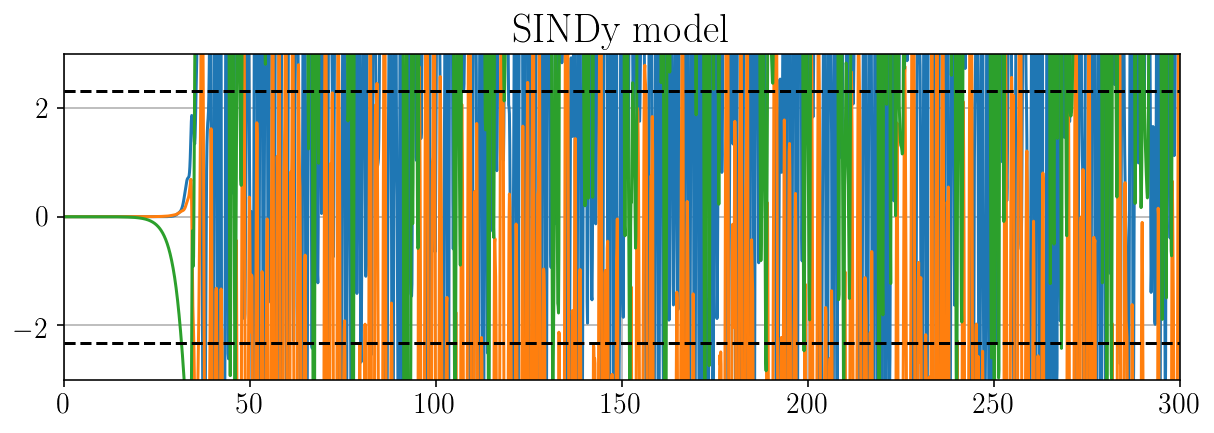

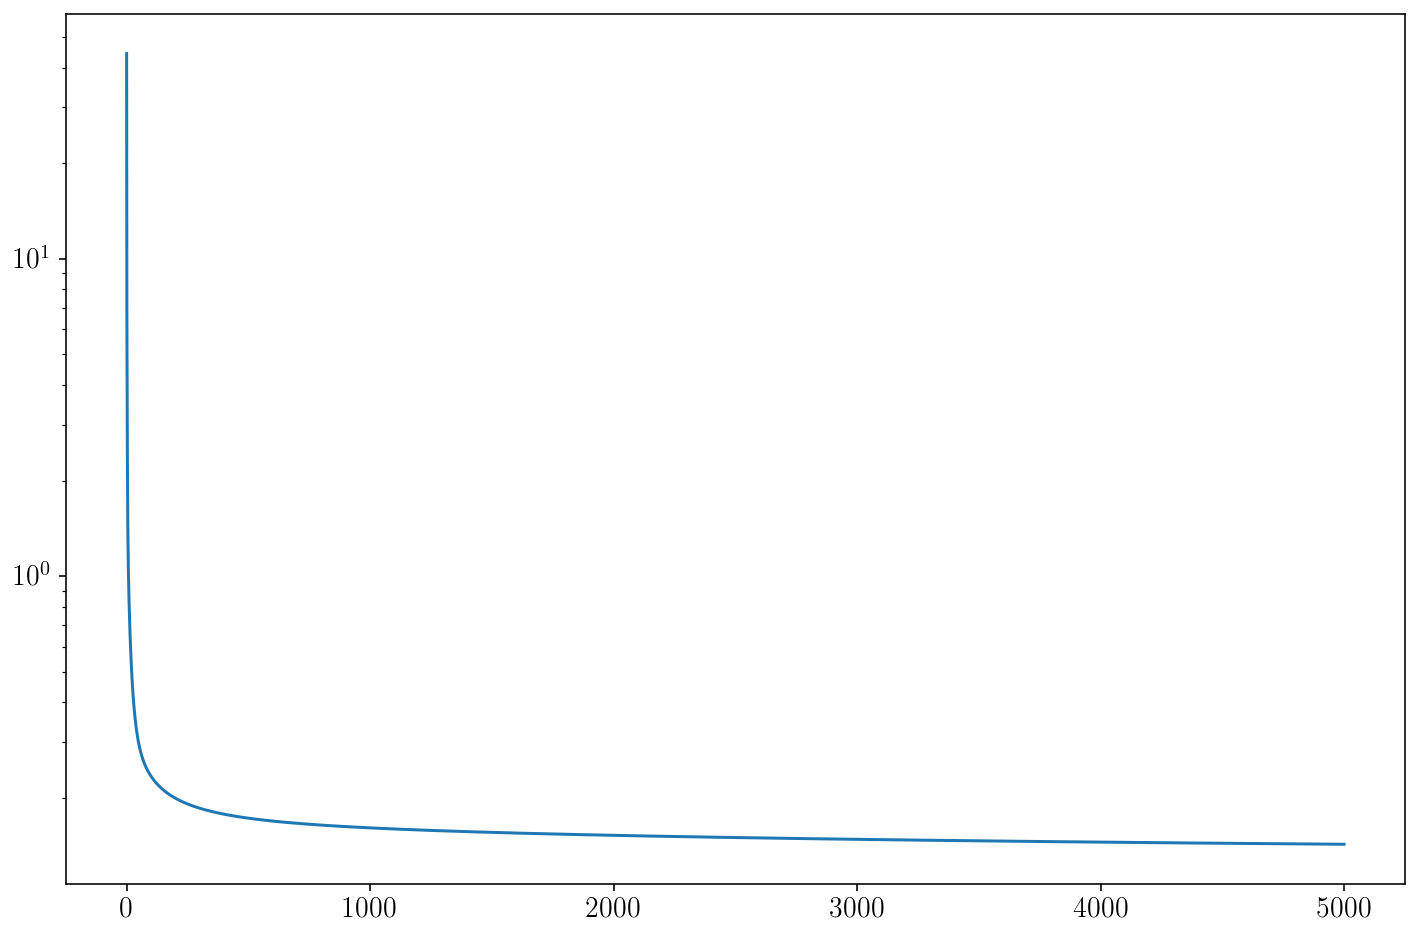

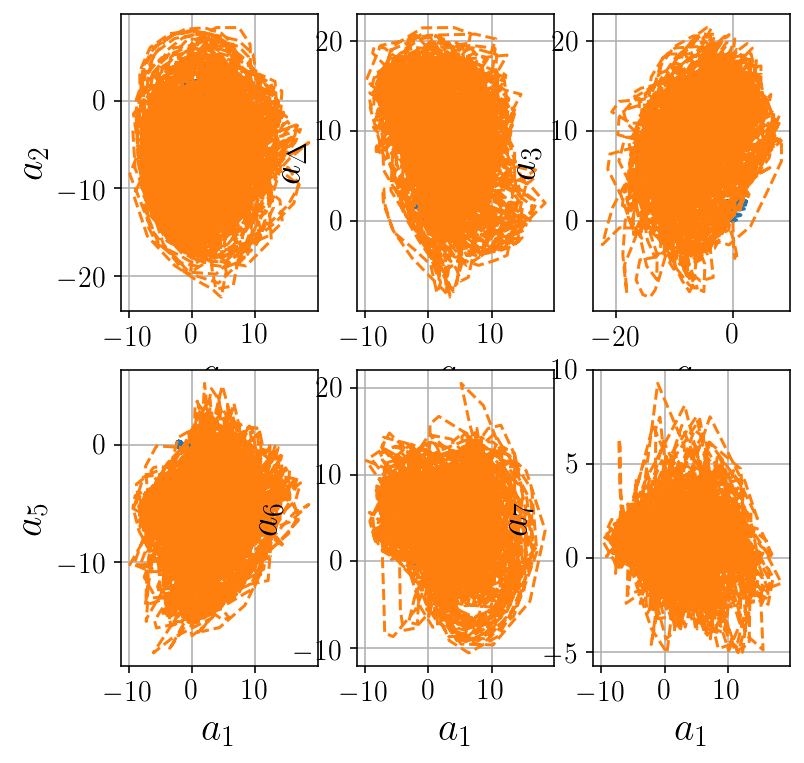

/media/akaptano/HITSI-Work/pysindy/pysindy/pysindy.py:339: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  "Control variables u were ignored because control variables were"


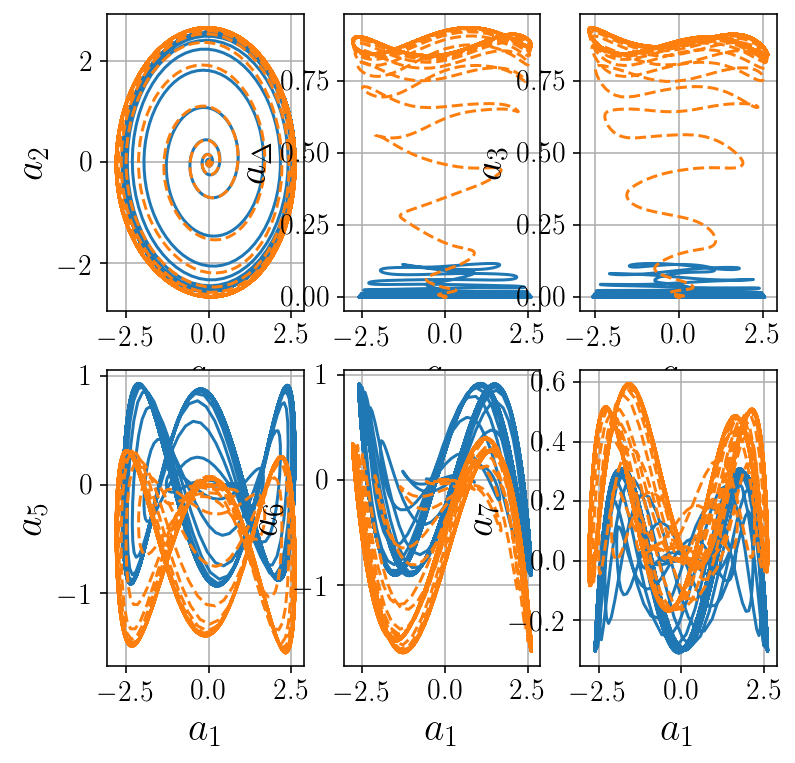

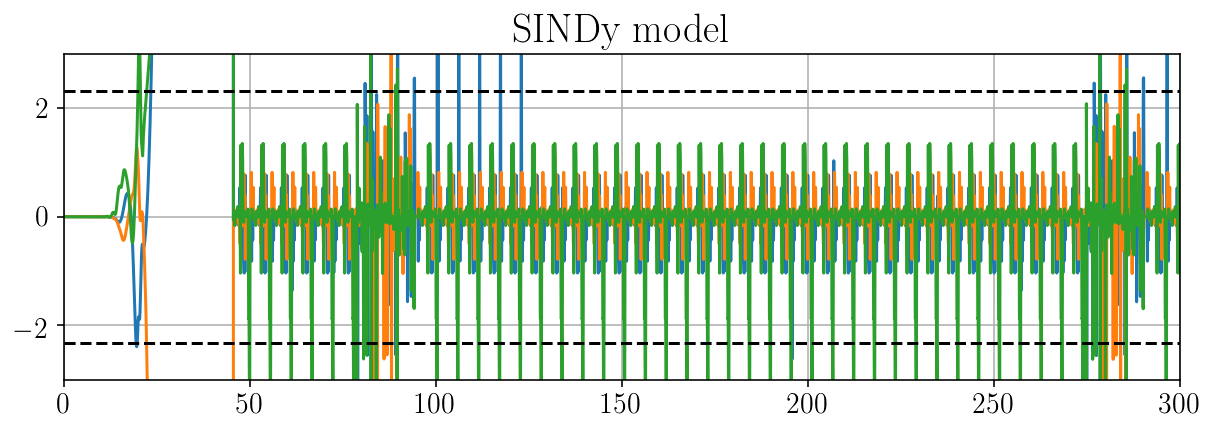

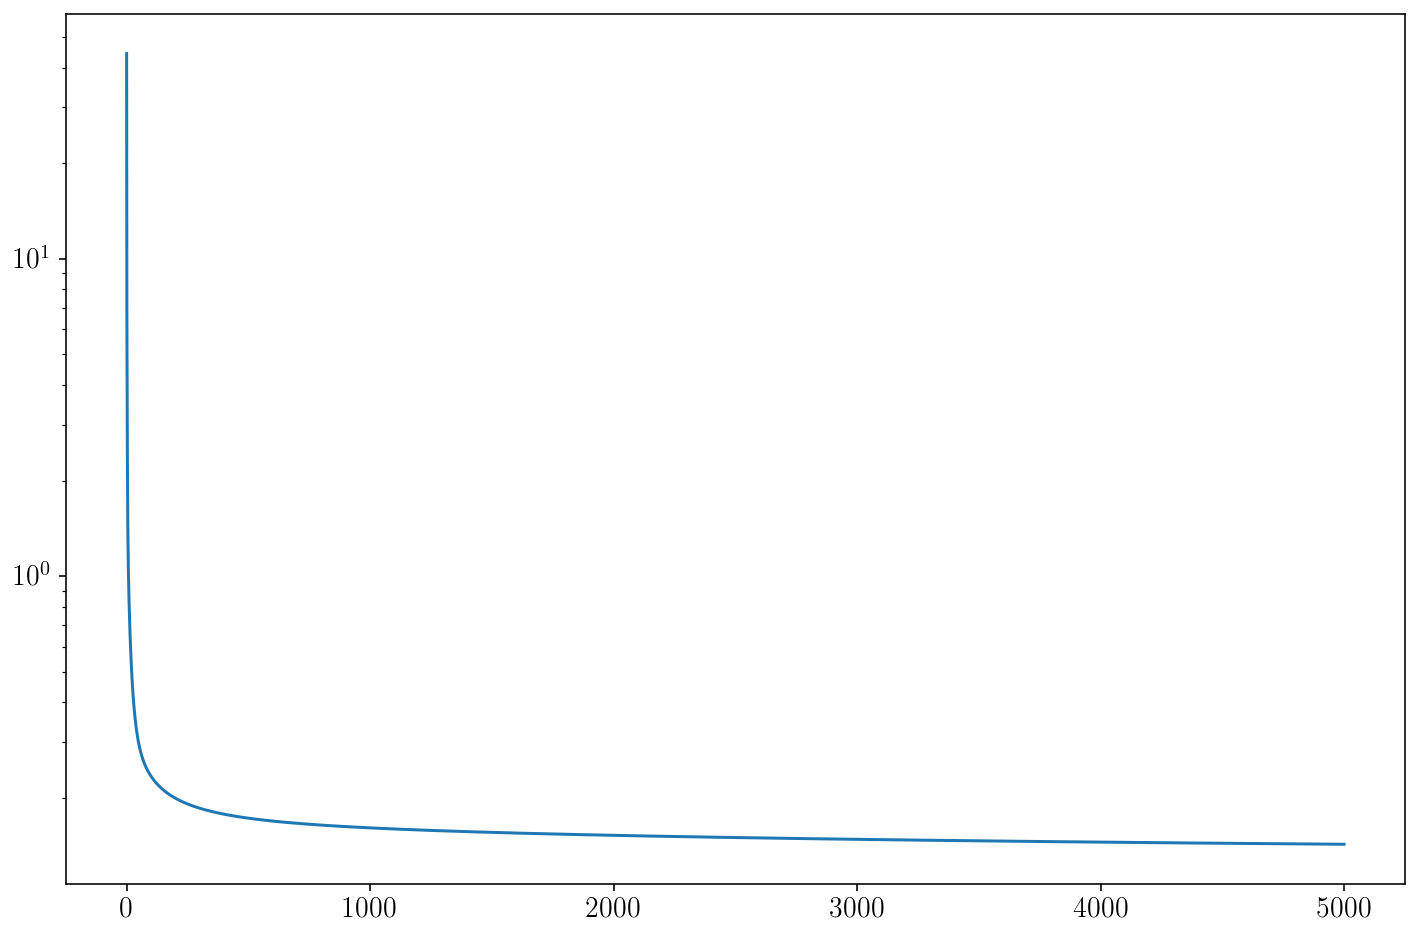

In [16]:
eta = 1e0
nu = 1e0
threshold = 0.0
sindy_opt = ps.testSR3(threshold=threshold, nu=nu, eta=eta,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=5000, tol=1e-10,
                            thresholder="l0", eigmin=-1e20, eigmax=-1, 
                            alpha=0.5*min(nu,eta), beta=0.5*eta,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
# Reproduces constrained sindy when eta is very large
# eta = 1e3
# sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta,
#                             PL=PL_tensor, PQ=PQ_tensor, max_iter=1000, tol=1e-10,
#                             thresholder="l0", eigmin=-1e20, eigmax=-1, 
#                             alpha=0.5*min(nu,eta), beta=0.5*eta,
#                             constraint_lhs=constraint_matrix,
#                             constraint_rhs=constraint_zeros,
#                             constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy_test = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy_test[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy_test[:, 1], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

a_dot = model.differentiate(a[:, :r], t)
a_dot_sindy_test = model.predict(a[:, :r], t)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a_dot[:, 1], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 1], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a_dot[:, 0], a_dot[:, 4])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a_dot[:, 0], a_dot[:, 5])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a_dot[:, 0], a_dot[:, 6])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy3[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)
plt.show()

In [17]:
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
Qsum = np.sum(Q + np.transpose(Q, [2, 1, 0]) + np.transpose(Q, [0, 2, 1])) 
print(Qsum)
print(np.dot(constraint_matrix, Xi.flatten()))
CCT_inv = np.linalg.pinv(np.dot(constraint_matrix, constraint_matrix.T))
shift = np.eye(r * Nr) - np.dot(constraint_matrix.T, np.dot(CCT_inv, constraint_matrix))
print(np.diag(np.eye(r * Nr) - np.dot(constraint_matrix.T, np.dot(CCT_inv, constraint_matrix))))

-3.4821995092967894e-13
[-4.79032338e-16  3.02353487e-18  6.18719606e-17 -1.14092714e-15
 -3.86349372e-14 -9.09830420e-14  8.62610653e-15  6.07471986e-16
  1.33736293e-15 -1.66533454e-16  4.88498131e-15 -2.66453526e-15
 -8.99280650e-15  9.99200722e-15  7.10542736e-15  1.16573418e-15
 -5.77315973e-15  1.55431223e-15 -3.33066907e-16 -8.88178420e-16
 -7.77156117e-16 -4.44089210e-16  2.22044605e-16  6.93889390e-17
  8.88178420e-16 -2.53130850e-14 -5.60662627e-14  1.77635684e-15
  3.55271368e-15 -2.22044605e-15  1.45439216e-14  7.99360578e-15
  0.00000000e+00  8.88178420e-16  3.77475828e-15  1.30007116e-13
 -2.48689958e-14  1.33226763e-14  3.55271368e-15  2.66453526e-14
 -1.64313008e-14  0.00000000e+00  5.32907052e-15  3.10862447e-15
  2.44249065e-15 -9.71445147e-17 -1.77635684e-15  1.77635684e-15
  0.00000000e+00 -2.22044605e-16  3.27515792e-15  2.66453526e-15
 -5.55111512e-15  8.88178420e-15  1.77635684e-15 -2.66453526e-15
  8.21565038e-15 -8.88178420e-15 -5.77315973e-15 -4.75175455e-14
 

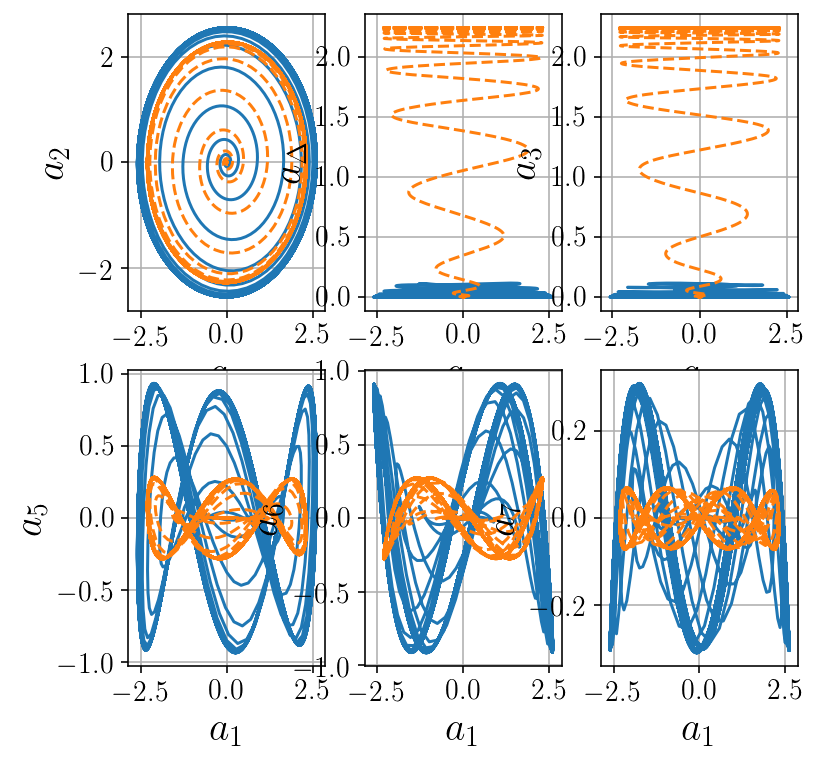

In [18]:
plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.plot(a[:, 0], a[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.plot(a[:, 0], a[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a_dot[:, 1], a_dot[:, -1])
plt.plot(a[:, 1], a[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a_dot[:, 0], a_dot[:, 4])
plt.plot(a[:, 0], a[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a_dot[:, 0], a_dot[:, 5])
plt.plot(a[:, 0], a[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a_dot[:, 0], a_dot[:, 6])
plt.plot(a[:, 0], a[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/wminimization_sr3.py:389: ConvergenceWarning: wSR3._reduce did not converge after 10000 iterations.


x0' = 0.099 x0 + -0.824 x1 + 0.018 x2 + 0.012 x3 + -0.380 x4 + 0.196 x5 + -0.031 x6 + 0.003 x7 + -0.002 x8 + 0.001 x0x1 + -0.128 x0x2 + -0.101 x0x3 + -0.008 x0x4 + 0.011 x0x6 + -0.087 x0x7 + -0.030 x0x8 + -0.057 x1x2 + 0.056 x1x3 + -0.005 x1x4 + 0.007 x1x5 + 0.095 x1x6 + 0.019 x1x7 + -0.167 x1x8 + 0.007 x2x3 + 0.726 x2x4 + 0.091 x2x5 + 0.017 x2x6 + 0.051 x2x7 + -0.004 x2x8 + -0.106 x3x4 + 0.748 x3x5 + 0.020 x3x6 + 0.023 x3x7 + -0.002 x3x8 + 0.005 x4x5 + -0.993 x4x6 + -0.714 x4x7 + 0.103 x4x8 + -0.681 x5x6 + 0.991 x5x7 + -0.093 x5x8 + 0.047 x6x7 + 0.015 x6x8 + -0.006 x7x8 + 0.001 x1x1 + -0.035 x2x2 + -0.010 x3x3 + 0.030 x4x4 + -0.005 x5x5 + -0.027 x6x6 + -0.007 x7x7
x1' = 0.818 x0 + 0.128 x1 + -0.003 x2 + -0.009 x3 + 0.236 x4 + 0.479 x5 + 0.022 x6 + -0.011 x7 + 0.003 x8 + -0.001 x0x1 + -0.119 x0x2 + -0.021 x0x3 + -0.005 x0x4 + 0.004 x0x5 + 0.132 x0x6 + -0.022 x0x7 + 0.139 x0x8 + -0.106 x1x2 + 0.076 x1x3 + 0.001 x1x4 + 0.003 x1x5 + 0.044 x1x6 + 0.149 x1x7 + -0.065 x1x8 + -0.021 x2x3 + -0

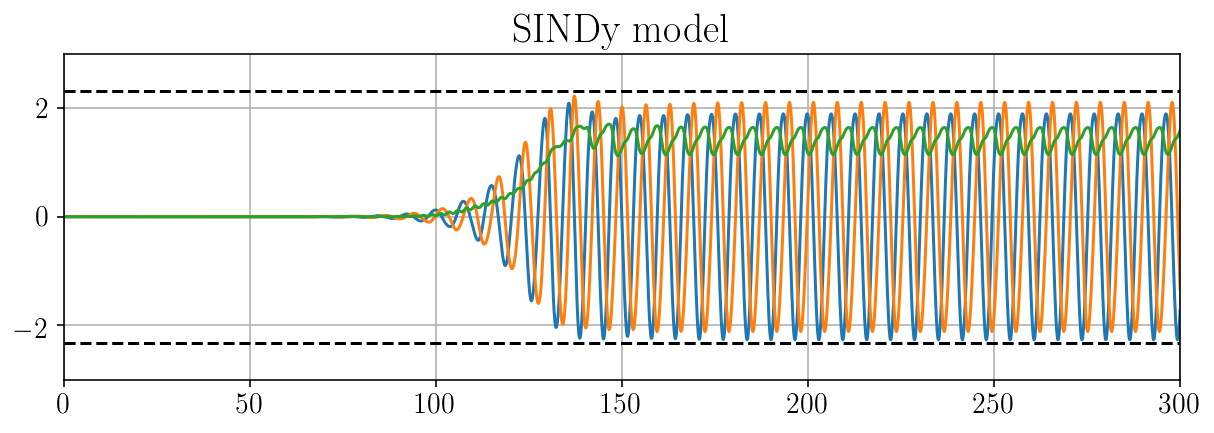

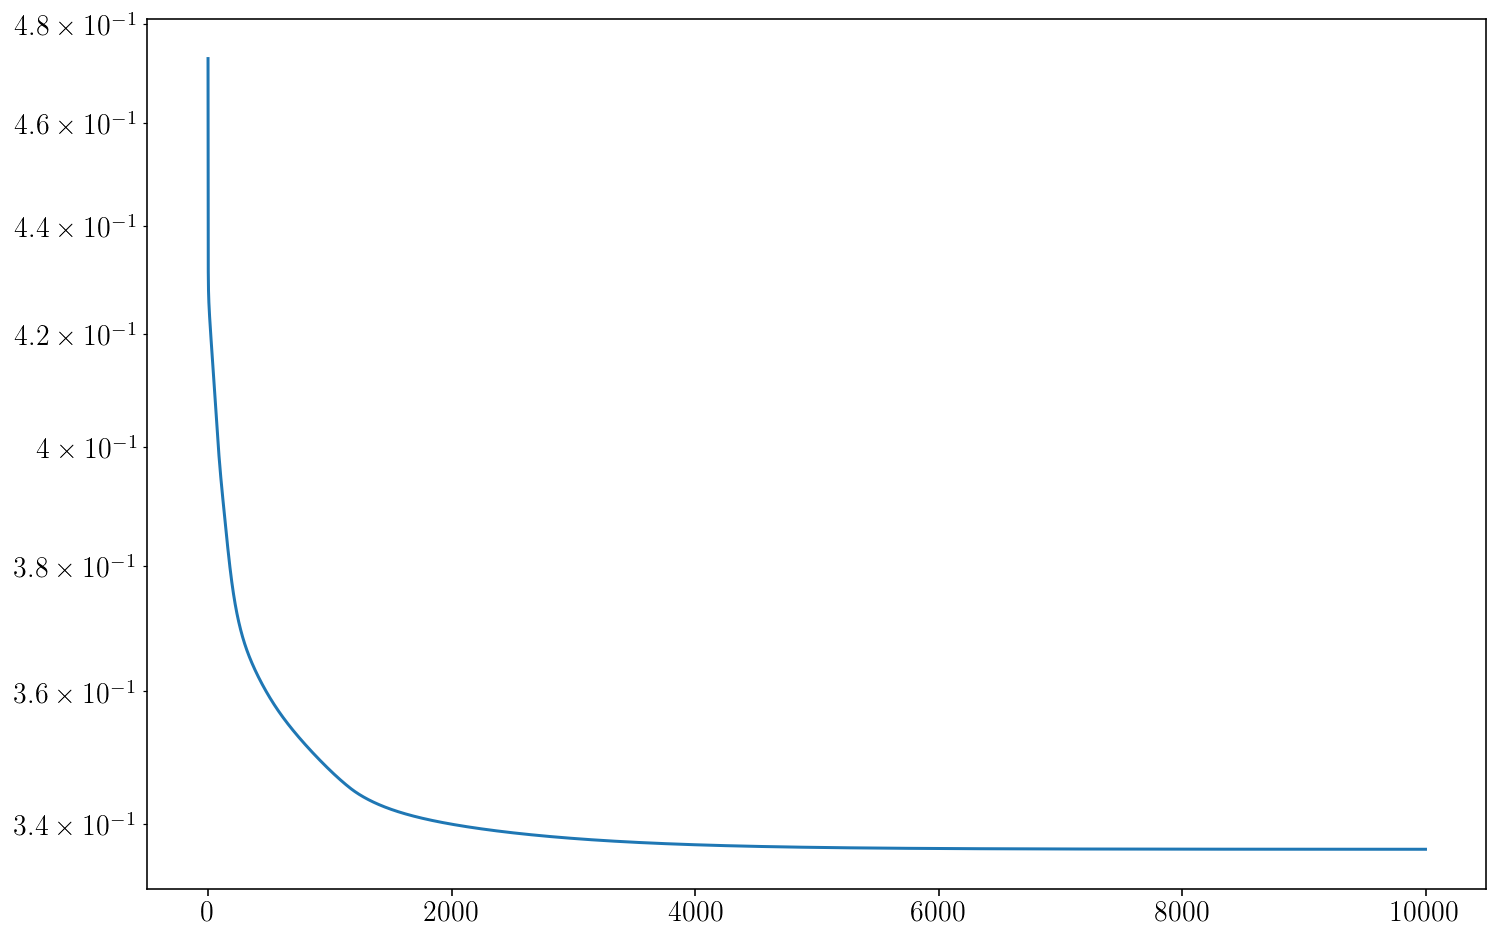

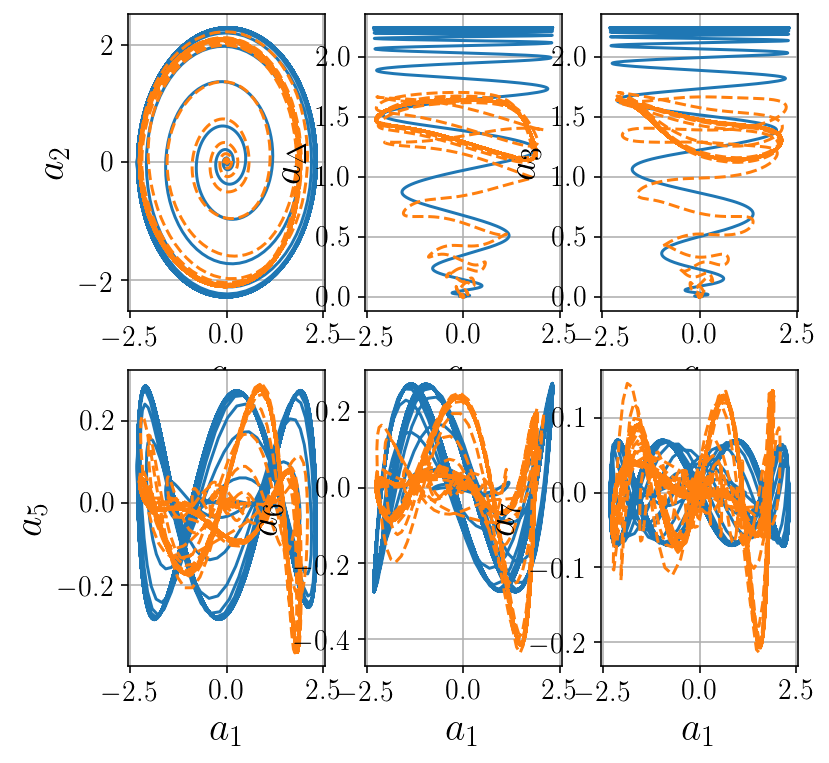

/media/akaptano/HITSI-Work/pysindy/pysindy/pysindy.py:339: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  "Control variables u were ignored because control variables were"


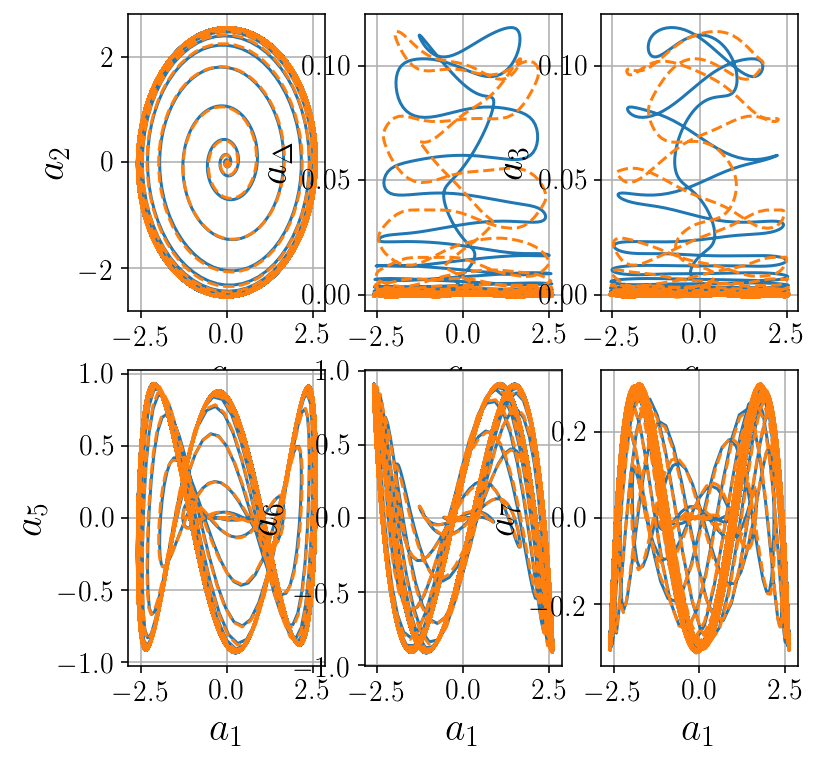

In [74]:
eta = 1.0
threshold = 0.0
sindy_opt = ps.wSR3(threshold=threshold, eta=eta,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=10000, tol=1e-10,
                            thresholder="l0", eigmin=-1e20, eigmax=-0.0,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")
# Reproduces constrained sindy when eta is very large
# eta = 1e3
# sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta,
#                             PL=PL_tensor, PQ=PQ_tensor, max_iter=1000, tol=1e-10,
#                             thresholder="l0", eigmin=-1e20, eigmax=-1, 
#                             alpha=0.5*min(nu,eta), beta=0.5*eta,
#                             constraint_lhs=constraint_matrix,
#                             constraint_rhs=constraint_zeros,
#                             constraint_order="feature")
model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True))
model.fit(a[:, :r], t=t)
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        #print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print(opt_m)
print('As eigvals: ', eigvals)
print(np.all(eigvals < 0))
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
a_sindy_test = model.simulate(a[300,:r], t_sim, integrator_kws=integrator_keywords)

plt.figure(figsize=(10, 3))
plt.plot(t_sim, a_sindy_test[:, [0, 1, -1]])
plt.plot([t_sim[0], t_sim[-1]], [a_max, a_max], 'k--')
plt.plot([t_sim[0], t_sim[-1]], [-a_max, -a_max], 'k--')
plt.ylim([-3, 3])
plt.xlim([0, 300])
plt.title('SINDy model')
plt.grid()
plt.figure()
plt.semilogy(sindy_opt.objective_history)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a[:, 0], a[:, 1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a[:, 0], a[:, -1])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a[:, 1], a[:, -1])
plt.plot(a_sindy_test[:, 1], a_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a[:, 0], a[:, 4])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a[:, 0], a[:, 5])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a[:, 0], a[:, 6])
plt.plot(a_sindy_test[:, 0], a_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()
plt.show()

a_dot = model.differentiate(a[:, :r], t)
a_dot_sindy_test = model.predict(a[:, :r], t)

plt.figure(figsize=(6, 6))
plt.subplot(231)
plt.plot(a_dot[:, 0], a_dot[:, 1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_2$')
plt.grid()

plt.subplot(232)
plt.plot(a_dot[:, 0], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_\Delta$')
plt.grid()

plt.subplot(233)
plt.plot(a_dot[:, 1], a_dot[:, -1])
plt.plot(a_dot_sindy_test[:, 1], a_dot_sindy_test[:, -1],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_3$')
plt.grid()

plt.subplot(234)
plt.plot(a_dot[:, 0], a_dot[:, 4])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 4],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_5$')
plt.grid()

plt.subplot(235)
plt.plot(a_dot[:, 0], a_dot[:, 5])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 5],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_6$')
plt.grid()

plt.subplot(236)
plt.plot(a_dot[:, 0], a_dot[:, 6])
plt.plot(a_dot_sindy_test[:, 0], a_dot_sindy_test[:, 6],'--')
plt.xlabel(r'$a_1$')
plt.ylabel(r'$a_7$')
plt.grid()

In [75]:
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
Qsum = np.sum(Q + np.transpose(Q, [2, 1, 0]) + np.transpose(Q, [0, 2, 1])) 
print(Qsum)
print(np.max(np.abs(Q + np.transpose(Q, [2, 1, 0]) + np.transpose(Q, [0, 2, 1]))))
print(np.dot(constraint_matrix, Xi.flatten()))
print(np.sum(np.dot(constraint_matrix, Xi.flatten())))
#CCT_inv = np.linalg.inv(np.dot(constraint_matrix, constraint_matrix.T))
#shift = np.eye(r * Nr) - np.dot(constraint_matrix.T, np.dot(CCT_inv, constraint_matrix))
#print(np.diag(np.eye(r * Nr) - np.dot(constraint_matrix.T, np.dot(CCT_inv, constraint_matrix))))

-1.612622309118912e-06
8.582590731067776e-07
[ 5.89582694e-11  1.94456996e-11  8.92796459e-10  6.71830602e-11
 -5.15532471e-10  2.29941564e-10  3.29015555e-08 -2.86086358e-07
 -1.15762421e-10 -5.00923747e-11 -2.47922571e-10 -2.08473239e-10
  2.29022135e-09  1.88856575e-09 -3.45700641e-08 -3.45158639e-08
  5.25401944e-12 -2.03783657e-11  8.21600565e-11 -1.25491795e-09
 -1.16216370e-09  1.44449217e-08  1.39993404e-08 -2.77644574e-12
  7.78072717e-10  9.23364496e-09  9.21136234e-09 -1.78224582e-07
 -1.68161932e-07  3.38985728e-10 -9.10222298e-09 -9.42736733e-09
  1.30705303e-07  1.20555342e-07 -7.85682630e-11 -3.87288424e-10
  5.50562618e-09  5.31781552e-09  6.24922336e-12  1.00264970e-08
  1.19193828e-08 -6.25774987e-11  3.32308900e-08  1.91112903e-10
  4.57276883e-10  5.90283378e-12 -3.73120201e-10 -5.96287464e-11
 -4.12768486e-10  4.52189397e-10 -5.14091880e-10 -3.93534094e-11
 -1.09302789e-10  2.65615085e-10  1.63424829e-11  1.07553078e-10
  1.54294355e-10 -7.03892056e-10 -1.36323308e

In [76]:
# Energy plots

# Energy of the models
E = np.sum(a**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_manifold = np.sum(a_manifold**2, axis=0)
E_sindy = np.sum(a_sindy**2, axis=1)
E_sindy2 = np.sum(a_sindy2**2, axis=1)
E_sindy3 = np.sum(a_sindy3**2, axis=1)
E_test = np.sum(a_sindy_test**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'k', label='DNS')
plt.plot(t_sim, E_manifold, label='Invariant manifold')
#plt.plot(t_sim, E_quadratic, label='Quadratic')
#plt.plot(t_sim, E_cubic, label='Cubic')
#plt.plot(t_sim, E_sindy, label=r'SINDy (cubic)')
plt.plot(t_sim, E_sindy2, label=r'SINDy (constrained quadratic)')
#plt.plot(t_sim, E_sindy3, 'm', label=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_test, 'm', labet, to thresholded least squares, and performs similarly in practice.
However, unlike thresholded least squares, the SR3 approach easily generalizes to new problems
and featuresl=r'SINDy (trapping quadratic)')
plt.plot(t_sim, E_galerkin3, label='POD-3')
plt.plot(t_sim, E_galerkin9, label='POD-9')

plt.legend(fontsize=14, loc=2)
plt.grid()
#plt.gca().set_yscale('log')
plt.xlim([0, 400])
plt.ylabel('Fluctuation energy')
#plt.gca().set_yscale('log')
#plt.ylim([1e-8, 1e3])
plt.show()

SyntaxError: invalid syntax (<ipython-input-76-4b24ff1ac515>, line 21)

In [ ]:
Aopt = sindy_opt.A_history_[-1]
mopt = sindy_opt.m_history_[-1]
#print(Aopt, mopt)
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = mopt
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = mopt
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
G = np.tensordot(P_tensor.T, Aopt, axes=([3, 2], [0, 1]))
PW = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1])) 
#print(PW)
eigA, eigvA = np.linalg.eig(Aopt)
eigW, eigvW = np.linalg.eig(PW)
print(eigA, eigW)
#print(np.linalg.norm(PW - Aopt)/np.linalg.norm(PW))

In [ ]:
Ls_true = 0.5 * (galerkin9['L'] + galerkin9['L'].T)
Q_true = np.zeros((r,r,r))
for i in range(r):
    Q_true[i, :, :] = 0.5 * (galerkin9['Q'][i, :, :] + galerkin9['Q'][i, :, :].T)
m_true = np.zeros(r)
m_true[r-1] = 10.0
print(m_true)
As_true = Ls_true - np.tensordot(m_true, Q_true, axes=([0, 0]))
eig_true, eigv_true = np.linalg.eig(As_true)
print(eig_true)
print(np.all(eig_true < 0))
smallest_eigval = np.min(eig_true)
largest_eigval = np.max(eig_true)
d = np.dot(Ls, m_true) + np.dot(np.tensordot(Q_true, m_true, axes=([2],[0])), m_true)
Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
print(Rm)

In [ ]:
x_expanded = np.zeros((a.shape[0]-2, r, Nr, r))
for i in range(r):
    x_expanded[:, i, :, i] = sindy_opt.Theta
x_expanded = np.reshape(x_expanded, ((a.shape[0]-2) * r, r * Nr))
xTx = np.dot(x_expanded.T, x_expanded)
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i + 1, r):
        mPQ[i, j, :, int((i + 1) / 2.0 * (2 * r - i)) + j - 1 - i] = mopt
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = mopt
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)
# Compute 4-index tensor P
p = PL_tensor - mPQ
#pTp = np.tensordot(p.T, np.transpose(p, [0, 1, 3, 2]), axes=([3, 2], [0, 1])).reshape(Nr * r, Nr * r)
pTp = np.reshape(np.tensordot(p.T, p, axes=([3, 2], [0, 1])), (Nr * r, Nr * r), 'F')
H = pTp / eta + xTx
#H = np.tensordot(p.T, p, axes=([3, 2], [0, 1]))
H_inv = np.linalg.pinv(H)
CHCT = np.dot(constraint_matrix, np.dot(H_inv, constraint_matrix.T))
CHCT_inv = np.linalg.pinv(CHCT)
mid = np.dot(constraint_matrix, H_inv) - np.dot(np.dot(np.dot(CHCT, CHCT_inv), constraint_matrix), H_inv)
G = np.tensordot(p.T, Aopt, axes=([3, 2], [0, 1])) / eta + np.dot(sindy_opt.Theta.T, sindy_opt.Xdot)
print(mid)
print(np.dot(mid, G.flatten()))
print(np.dot(constraint_matrix, Xi.flatten()))